In [1]:
import sys
import tools_matrix as tools
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from MTCNN import create_Kao_Onet, create_Kao_Rnet, create_Kao_Pnet

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [36]:
Pnet = create_Kao_Pnet(r'12net.h5')
Rnet = create_Kao_Rnet(r'24net.h5')
Onet = create_Kao_Onet(r'48net.h5')  # will not work. caffe and TF incompatible

In [40]:
Pnet = create_Kao_Pnet(r'12net.h5')
Rnet = create_Kao_Rnet(r'24net.h5')
Onet = create_Kao_Onet(r'48net.h5')  # will not work. caffe and TF incompatible


def detectFace(img, threshold):

    caffe_img = (img.copy() - 127.5) / 127.5
    origin_h, origin_w, ch = caffe_img.shape
    scales = tools.calculateScales(img)
    out = []
    t0 = time.time()
    # del scales[:4]

    for scale in scales:
        hs = int(origin_h * scale)
        ws = int(origin_w * scale)
        scale_img = cv2.resize(caffe_img, (ws, hs))
        input = scale_img.reshape(1, *scale_img.shape)
        ouput = Pnet.predict(input)  # .transpose(0,2,1,3) should add, but seems after process is wrong then.
        out.append(ouput)
    image_num = len(scales)
    rectangles = []
    for i in range(image_num):
        cls_prob = out[i][0][0][:, :,
                   1]  # i = #scale, first 0 select cls score, second 0 = batchnum, alway=0. 1 one hot repr
        roi = out[i][1][0]
        out_h, out_w = cls_prob.shape
        out_side = max(out_h, out_w)
        # print('calculating img scale #:', i)
        cls_prob = np.swapaxes(cls_prob, 0, 1)
        roi = np.swapaxes(roi, 0, 2)
        rectangle = tools.detect_face_12net(cls_prob, roi, out_side, 1 / scales[i], origin_w, origin_h, threshold[0])
        rectangles.extend(rectangle)
    rectangles = tools.NMS(rectangles, 0.7, 'iou')

    t1 = time.time()
    print ('time for 12 net is: ', t1-t0, len(rectangles))

    if len(rectangles) == 0:
        return rectangles

    crop_number = 0
    out = []
    predict_24_batch = []
    for rectangle in rectangles:
        crop_img = caffe_img[int(rectangle[1]):int(rectangle[3]), int(rectangle[0]):int(rectangle[2])]
        scale_img = cv2.resize(crop_img, (24, 24))
        predict_24_batch.append(scale_img)
        crop_number += 1

    predict_24_batch = np.array(predict_24_batch)

    out = Rnet.predict(predict_24_batch)

    cls_prob = out[0]  # first 0 is to select cls, second batch number, always =0
    cls_prob = np.array(cls_prob)  # convert to numpy
    roi_prob = out[1]  # first 0 is to select roi, second batch number, always =0
    roi_prob = np.array(roi_prob)
    rectangles = tools.filter_face_24net(cls_prob, roi_prob, rectangles, origin_w, origin_h, threshold[1])
    t2 = time.time()
    print ('time for 24 net is: ', t2-t1, len(rectangles))


    if len(rectangles) == 0:
        return rectangles


    crop_number = 0
    predict_batch = []
    for rectangle in rectangles:
        # print('calculating net 48 crop_number:', crop_number)
        crop_img = caffe_img[int(rectangle[1]):int(rectangle[3]), int(rectangle[0]):int(rectangle[2])]
        scale_img = cv2.resize(crop_img, (48, 48))
        predict_batch.append(scale_img)
        crop_number += 1

    predict_batch = np.array(predict_batch)

    output = Onet.predict(predict_batch)
    cls_prob = output[0]
    roi_prob = output[1]
    pts_prob = output[2]  # index
    # rectangles = tools.filter_face_48net_newdef(cls_prob, roi_prob, pts_prob, rectangles, origin_w, origin_h,
    #                                             threshold[2])
    rectangles = tools.filter_face_48net(cls_prob, roi_prob, pts_prob, rectangles, origin_w, origin_h, threshold[2])
    t3 = time.time()
    print ('time for 48 net is: ', t3-t2, len(rectangles))

    return rectangles

In [208]:
threshold = [0.1,0.3,0.3]
# video_path = 'WalmartArguments_p1.mkv'
# cap = cv2.VideoCapture(video_path)
imgs = [x for x in range(20)]
draws = []
for x in imgs:
    # ret, img = cap.read()
    img = cv2.imread('{}.png'.format(x))
    rectangles = detectFace(img, threshold)
    print(len(rectangles), ' faces')
    draw = img.copy()

    for rectangle in rectangles:
        if rectangle is not None:
            W = -int(rectangle[0]) + int(rectangle[2])
            H = -int(rectangle[1]) + int(rectangle[3])
            paddingH = 0.01 * W
            paddingW = 0.02 * H
            crop_img = img[int(rectangle[1]+paddingH):int(rectangle[3]-paddingH), int(rectangle[0]-paddingW):int(rectangle[2]+paddingW)]
            crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY)
            if crop_img is None:
                continue
            if crop_img.shape[0] < 0 or crop_img.shape[1] < 0:
                continue
            cv2.rectangle(draw, (int(rectangle[0]), int(rectangle[1])), (int(rectangle[2]), int(rectangle[3])), (255, 0, 0), 1)

            for i in range(5, 15, 2):
                cv2.circle(draw, (int(rectangle[i + 0]), int(rectangle[i + 1])), 2, (0, 255, 0))
    draws.append(draw)

('time for 12 net is: ', 0.055177927017211914, 288)
('time for 24 net is: ', 0.0237729549407959, 2)
('time for 48 net is: ', 0.002619028091430664, 1)
(1, ' faces')
('time for 12 net is: ', 0.06541085243225098, 351)
('time for 24 net is: ', 0.027871131896972656, 1)
('time for 48 net is: ', 0.0022268295288085938, 0)
(0, ' faces')
('time for 12 net is: ', 0.048246145248413086, 198)
('time for 24 net is: ', 0.016717910766601562, 1)
('time for 48 net is: ', 0.00215911865234375, 1)
(1, ' faces')
('time for 12 net is: ', 0.04493093490600586, 136)
('time for 24 net is: ', 0.012452125549316406, 1)
('time for 48 net is: ', 0.0023920536041259766, 0)
(0, ' faces')
('time for 12 net is: ', 0.042669057846069336, 112)
('time for 24 net is: ', 0.009885072708129883, 1)
('time for 48 net is: ', 0.002279996871948242, 1)
(1, ' faces')
('time for 12 net is: ', 0.04355001449584961, 124)
('time for 24 net is: ', 0.010531902313232422, 0)
(0, ' faces')
('time for 12 net is: ', 0.06097006797790527, 359)
('time 

In [351]:
def get_face(img):
    threshold = [0.1,0.3,0.3]
    # ret, img = cap.read()
    img = cv2.imread(img)
    rectangles = detectFace(img, threshold)
    draw = np.zeros(img.shape)

    for rectangle in rectangles:
        if rectangle is not None:
            print(np.round(np.array(rectangle)))
            W = -int(rectangle[0]) + int(rectangle[2])
            H = -int(rectangle[1]) + int(rectangle[3])
            paddingH = 0.01 * W
            paddingW = 0.02 * H
            for row in range(draw.shape[0]):
                for px in range(draw.shape[1]):
                    if row > int(rectangle[1]+paddingH) and row < int(rectangle[3]-paddingH):
                        if px > int(rectangle[0]-paddingW) and px < int(rectangle[2]+paddingW):
                            draw[row][px] = img[row][px]
    return draw.astype('uint8')[:,:,[2,1,0]]
    

In [250]:
from PIL import Image
import random
import skimage.io

In [358]:
background_path = '/home/jean/bazar/data/128x128/cropped/nude/backgrounds'
persons_path = '/home/jean/bazar/data/128x128/cropped/black/persons'
faces_path = '/home/jean/bazar/data/128x128/cropped/nude/faces'
for f in range(5059):
    face = get_face(persons_path+'/{}.png'.format(f))
    background = skimage.io.imread(background_path+'/{}.png'.format(f))
    for row in range(face.shape[0]):
        for px in range(face.shape[1]):
            if face[row][px].all() != np.zeros(3).all():
                background[row][px] = face[row][px]
    image = Image.fromarray(background.astype('uint8'), 'RGB')
    image.save(faces_path+'/{}.png'.format(f))
    
    

('time for 12 net is: ', 0.0538020133972168, 288)
('time for 24 net is: ', 0.022854089736938477, 2)
('time for 48 net is: ', 0.0025827884674072266, 1)
[ 85.  28. 103.  50.   1.  88.  38.  96.  35.  91.  41.  91.  47.  97.
  45.]
('time for 12 net is: ', 0.06324100494384766, 351)
('time for 24 net is: ', 0.028869152069091797, 1)
('time for 48 net is: ', 0.0024559497833251953, 0)
('time for 12 net is: ', 0.04779696464538574, 198)
('time for 24 net is: ', 0.01649308204650879, 1)
('time for 48 net is: ', 0.002768993377685547, 1)
[59. 23. 77. 44.  1. 67. 31. 74. 33. 71. 36. 66. 39. 71. 41.]
('time for 12 net is: ', 0.04465985298156738, 136)
('time for 24 net is: ', 0.012022972106933594, 1)
('time for 48 net is: ', 0.0021681785583496094, 0)
('time for 12 net is: ', 0.04140496253967285, 112)
('time for 24 net is: ', 0.009614944458007812, 1)
('time for 48 net is: ', 0.0023970603942871094, 1)
[51.  9. 66. 28.  1. 57. 18. 64. 17. 62. 22. 59. 26. 64. 25.]
('time for 12 net is: ', 0.04166603088378

('time for 12 net is: ', 0.04329085350036621, 161)
('time for 24 net is: ', 0.013772010803222656, 0)
('time for 12 net is: ', 0.05881500244140625, 319)
('time for 24 net is: ', 0.024769067764282227, 2)
('time for 48 net is: ', 0.0033299922943115234, 1)
[52. 22. 81. 55.  0. 64. 33. 75. 39. 66. 41. 59. 46. 67. 51.]
('time for 12 net is: ', 0.0467381477355957, 199)
('time for 24 net is: ', 0.01718306541442871, 1)
('time for 48 net is: ', 0.002351999282836914, 0)
('time for 12 net is: ', 0.04363393783569336, 159)
('time for 24 net is: ', 0.012516021728515625, 1)
('time for 48 net is: ', 0.002276897430419922, 1)
[52. 17. 67. 37.  1. 60. 27. 67. 26. 65. 31. 61. 34. 67. 34.]
('time for 12 net is: ', 0.045346975326538086, 175)
('time for 24 net is: ', 0.014636039733886719, 1)
('time for 48 net is: ', 0.0022919178009033203, 1)
[ 94.   9. 112.  33.   1. 103.  19. 111.  20. 109.  24. 102.  27. 109.
  29.]
('time for 12 net is: ', 0.05190086364746094, 259)
('time for 24 net is: ', 0.02176499366760

('time for 12 net is: ', 0.05008697509765625, 69)
('time for 24 net is: ', 0.0072400569915771484, 0)
('time for 12 net is: ', 0.04703712463378906, 214)
('time for 24 net is: ', 0.01751089096069336, 1)
('time for 48 net is: ', 0.0022399425506591797, 1)
[65. 23. 83. 45.  0. 74. 32. 79. 32. 78. 37. 74. 41. 78. 41.]
('time for 12 net is: ', 0.06543707847595215, 423)
('time for 24 net is: ', 0.033576011657714844, 3)
('time for 48 net is: ', 0.0026650428771972656, 0)
('time for 12 net is: ', 0.04961585998535156, 210)
('time for 24 net is: ', 0.01679706573486328, 2)
('time for 48 net is: ', 0.002989053726196289, 0)
('time for 12 net is: ', 0.04459190368652344, 170)
('time for 24 net is: ', 0.014368057250976562, 2)
('time for 48 net is: ', 0.002393007278442383, 0)
('time for 12 net is: ', 0.05600285530090332, 304)
('time for 24 net is: ', 0.024955034255981445, 1)
('time for 48 net is: ', 0.0023779869079589844, 1)
[27. 23. 41. 40.  1. 32. 31. 38. 31. 35. 34. 32. 37. 38. 37.]
('time for 12 net i

('time for 12 net is: ', 0.049726009368896484, 205)
('time for 24 net is: ', 0.017355918884277344, 1)
('time for 48 net is: ', 0.002135038375854492, 1)
[52. 18. 68. 40.  1. 59. 28. 66. 27. 64. 33. 60. 37. 66. 37.]
('time for 12 net is: ', 0.05520486831665039, 291)
('time for 24 net is: ', 0.023659944534301758, 2)
('time for 48 net is: ', 0.0026361942291259766, 0)
('time for 12 net is: ', 0.044850826263427734, 165)
('time for 24 net is: ', 0.014963150024414062, 2)
('time for 48 net is: ', 0.0025649070739746094, 1)
[42. 20. 69. 53.  1. 49. 34. 61. 32. 55. 40. 51. 48. 60. 47.]
('time for 12 net is: ', 0.048705101013183594, 224)
('time for 24 net is: ', 0.01802992820739746, 1)
('time for 48 net is: ', 0.0025250911712646484, 1)
[51. 20. 68. 42.  1. 57. 29. 65. 30. 61. 34. 57. 38. 63. 38.]
('time for 12 net is: ', 0.051254987716674805, 239)
('time for 24 net is: ', 0.019536972045898438, 1)
('time for 48 net is: ', 0.0021109580993652344, 0)
('time for 12 net is: ', 0.049726009368896484, 203)


('time for 12 net is: ', 0.04444408416748047, 161)
('time for 24 net is: ', 0.014574050903320312, 0)
('time for 12 net is: ', 0.053212881088256836, 269)
('time for 24 net is: ', 0.021194934844970703, 0)
('time for 12 net is: ', 0.05611610412597656, 320)
('time for 24 net is: ', 0.02495288848876953, 0)
('time for 12 net is: ', 0.05714988708496094, 287)
('time for 24 net is: ', 0.024120092391967773, 2)
('time for 48 net is: ', 0.002817869186401367, 2)
[79. 10. 93. 29.  1. 83. 19. 90. 19. 85. 22. 83. 26. 89. 26.]
[42. 25. 54. 41.  1. 48. 32. 54. 33. 52. 36. 48. 38. 52. 39.]
('time for 12 net is: ', 0.048753976821899414, 216)
('time for 24 net is: ', 0.01727581024169922, 1)
('time for 48 net is: ', 0.0022611618041992188, 1)
[52. 14. 71. 39.  1. 59. 26. 69. 25. 65. 32. 60. 35. 68. 35.]
('time for 12 net is: ', 0.05348801612854004, 252)
('time for 24 net is: ', 0.02019500732421875, 2)
('time for 48 net is: ', 0.0026750564575195312, 2)
[44. 57. 68. 87.  1. 54. 67. 64. 68. 60. 75. 54. 80. 61. 

('time for 12 net is: ', 0.05283403396606445, 207)
('time for 24 net is: ', 0.01768207550048828, 0)
('time for 12 net is: ', 0.042997121810913086, 138)
('time for 24 net is: ', 0.012449979782104492, 0)
('time for 12 net is: ', 0.04103994369506836, 103)
('time for 24 net is: ', 0.009387969970703125, 0)
('time for 12 net is: ', 0.039765119552612305, 92)
('time for 24 net is: ', 0.00761103630065918, 1)
('time for 48 net is: ', 0.0024700164794921875, 0)
('time for 12 net is: ', 0.0651240348815918, 331)
('time for 24 net is: ', 0.027920961380004883, 2)
('time for 48 net is: ', 0.002841949462890625, 1)
[ 8. 59. 28. 82.  1. 15. 69. 23. 66. 20. 72. 18. 78. 25. 76.]
('time for 12 net is: ', 0.04123806953430176, 106)
('time for 24 net is: ', 0.009506940841674805, 1)
('time for 48 net is: ', 0.002132892608642578, 0)
('time for 12 net is: ', 0.0495297908782959, 246)
('time for 24 net is: ', 0.02029109001159668, 2)
('time for 48 net is: ', 0.002507925033569336, 1)
[58. 18. 71. 35.  1. 65. 25. 71. 2

('time for 12 net is: ', 0.044042110443115234, 164)
('time for 24 net is: ', 0.015784025192260742, 3)
('time for 48 net is: ', 0.0028400421142578125, 1)
[51. 31. 67. 50.  0. 57. 40. 64. 39. 60. 44. 57. 47. 64. 47.]
('time for 12 net is: ', 0.07692694664001465, 536)
('time for 24 net is: ', 0.04404807090759277, 1)
('time for 48 net is: ', 0.0023550987243652344, 0)
('time for 12 net is: ', 0.043264150619506836, 147)
('time for 24 net is: ', 0.01199793815612793, 1)
('time for 48 net is: ', 0.0022439956665039062, 1)
[57. 12. 76. 37.  1. 64. 24. 72. 23. 69. 28. 66. 33. 73. 32.]
('time for 12 net is: ', 0.049427032470703125, 193)
('time for 24 net is: ', 0.017063140869140625, 1)
('time for 48 net is: ', 0.0021469593048095703, 0)
('time for 12 net is: ', 0.04260396957397461, 132)
('time for 24 net is: ', 0.011501073837280273, 0)
('time for 12 net is: ', 0.05194401741027832, 205)
('time for 24 net is: ', 0.01745295524597168, 0)
('time for 12 net is: ', 0.04332304000854492, 148)
('time for 24 n

('time for 24 net is: ', 0.034919023513793945, 10)
('time for 48 net is: ', 0.004146099090576172, 1)
[65.  1. 89. 30.  1. 76. 12. 86. 15. 79. 19. 71. 24. 80. 27.]
('time for 12 net is: ', 0.04508709907531738, 171)
('time for 24 net is: ', 0.01497793197631836, 1)
('time for 48 net is: ', 0.0022821426391601562, 1)
[48. 21. 75. 55.  1. 57. 33. 71. 34. 64. 43. 56. 47. 68. 48.]
('time for 12 net is: ', 0.04594898223876953, 195)
('time for 24 net is: ', 0.016206979751586914, 1)
('time for 48 net is: ', 0.0022470951080322266, 0)
('time for 12 net is: ', 0.039155006408691406, 93)
('time for 24 net is: ', 0.007862091064453125, 2)
('time for 48 net is: ', 0.00257110595703125, 0)
('time for 12 net is: ', 0.046758174896240234, 200)
('time for 24 net is: ', 0.017386913299560547, 1)
('time for 48 net is: ', 0.0022439956665039062, 1)
[14. 42. 38. 72.  1. 23. 56. 35. 55. 30. 63. 25. 68. 34. 68.]
('time for 12 net is: ', 0.04115104675292969, 108)
('time for 24 net is: ', 0.009778022766113281, 0)
('time

('time for 12 net is: ', 0.05533599853515625, 269)
('time for 24 net is: ', 0.0220491886138916, 2)
('time for 48 net is: ', 0.0031638145446777344, 1)
[44. 13. 83. 64.  1. 68. 33. 80. 37. 79. 43. 67. 53. 74. 55.]
('time for 12 net is: ', 0.0502779483795166, 260)
('time for 24 net is: ', 0.021998167037963867, 1)
('time for 48 net is: ', 0.0023708343505859375, 1)
[61. 12. 79. 37.  1. 70. 23. 78. 24. 74. 30. 68. 33. 76. 34.]
('time for 12 net is: ', 0.04616808891296387, 186)
('time for 24 net is: ', 0.01612401008605957, 1)
('time for 48 net is: ', 0.002240896224975586, 1)
[49. 35. 62. 51.  0. 53. 41. 58. 41. 54. 45. 53. 49. 57. 49.]
('time for 12 net is: ', 0.060753822326660156, 353)
('time for 24 net is: ', 0.0297701358795166, 2)
('time for 48 net is: ', 0.002530813217163086, 0)
('time for 12 net is: ', 0.04184103012084961, 120)
('time for 24 net is: ', 0.009682893753051758, 0)
('time for 12 net is: ', 0.03980588912963867, 85)
('time for 24 net is: ', 0.007589101791381836, 0)
('time for 1

('time for 12 net is: ', 0.0419621467590332, 121)
('time for 24 net is: ', 0.009931802749633789, 1)
('time for 48 net is: ', 0.0023250579833984375, 1)
[53. 17. 77. 48.  1. 63. 30. 74. 33. 67. 39. 60. 42. 69. 44.]
('time for 12 net is: ', 0.049169063568115234, 227)
('time for 24 net is: ', 0.02084803581237793, 1)
('time for 48 net is: ', 0.002382993698120117, 1)
[50. 26. 64. 43.  1. 57. 34. 63. 34. 61. 38. 58. 41. 63. 41.]
('time for 12 net is: ', 0.05337691307067871, 273)
('time for 24 net is: ', 0.02155613899230957, 1)
('time for 48 net is: ', 0.002307891845703125, 1)
[54. 22. 86. 65.  1. 67. 39. 82. 42. 74. 49. 64. 54. 77. 57.]
('time for 12 net is: ', 0.05378413200378418, 252)
('time for 24 net is: ', 0.021368026733398438, 2)
('time for 48 net is: ', 0.002655029296875, 1)
[46.  8. 66. 34.  1. 54. 20. 64. 21. 58. 27. 53. 31. 61. 31.]
('time for 12 net is: ', 0.04840397834777832, 196)
('time for 24 net is: ', 0.016597986221313477, 2)
('time for 48 net is: ', 0.002502918243408203, 0)
(

('time for 12 net is: ', 0.04974102973937988, 240)
('time for 24 net is: ', 0.01924419403076172, 2)
('time for 48 net is: ', 0.0026199817657470703, 1)
[64. 12. 89. 44.  1. 70. 26. 81. 25. 74. 33. 71. 38. 81. 38.]
('time for 12 net is: ', 0.042073965072631836, 135)
('time for 24 net is: ', 0.01217198371887207, 1)
('time for 48 net is: ', 0.0022721290588378906, 0)
('time for 12 net is: ', 0.043881893157958984, 144)
('time for 24 net is: ', 0.012649059295654297, 1)
('time for 48 net is: ', 0.002259969711303711, 1)
[36. 14. 57. 39.  1. 43. 26. 52. 24. 50. 30. 48. 36. 54. 34.]
('time for 12 net is: ', 0.04498100280761719, 166)
('time for 24 net is: ', 0.01411890983581543, 2)
('time for 48 net is: ', 0.002619028091430664, 1)
[45. 11. 57. 28.  1. 50. 18. 56. 18. 54. 21. 51. 25. 56. 25.]
('time for 12 net is: ', 0.0734100341796875, 451)
('time for 24 net is: ', 0.036498069763183594, 1)
('time for 48 net is: ', 0.002270936965942383, 1)
[51. 15. 67. 36.  1. 57. 25. 65. 25. 62. 30. 58. 33. 65. 33

('time for 12 net is: ', 0.042669057846069336, 104)
('time for 24 net is: ', 0.010636091232299805, 1)
('time for 48 net is: ', 0.0022499561309814453, 1)
[77. 39. 88. 56.  1. 82. 47. 87. 48. 84. 51. 81. 54. 85. 54.]
('time for 12 net is: ', 0.06907391548156738, 434)
('time for 24 net is: ', 0.034922122955322266, 2)
('time for 48 net is: ', 0.0027840137481689453, 1)
[40. 16. 68. 54.  1. 45. 33. 57. 31. 48. 41. 47. 48. 57. 47.]
('time for 12 net is: ', 0.04671192169189453, 181)
('time for 24 net is: ', 0.015258073806762695, 1)
('time for 48 net is: ', 0.002318859100341797, 1)
[37.  4. 96. 70.  1. 65. 25. 89. 24. 86. 29. 76. 53. 92. 51.]
('time for 12 net is: ', 0.05021500587463379, 241)
('time for 24 net is: ', 0.01918506622314453, 2)
('time for 48 net is: ', 0.002557039260864258, 0)
('time for 12 net is: ', 0.05082201957702637, 233)
('time for 24 net is: ', 0.0189359188079834, 1)
('time for 48 net is: ', 0.0022881031036376953, 0)
('time for 12 net is: ', 0.03785991668701172, 55)
('time f

('time for 12 net is: ', 0.0480961799621582, 212)
('time for 24 net is: ', 0.01733994483947754, 2)
('time for 48 net is: ', 0.002507925033569336, 1)
[55.  2. 89. 45.  1. 64. 20. 80. 20. 71. 29. 66. 37. 78. 37.]
('time for 12 net is: ', 0.03863215446472168, 64)
('time for 24 net is: ', 0.00597691535949707, 2)
('time for 48 net is: ', 0.0026450157165527344, 1)
[43. 22. 54. 37.  0. 48. 28. 54. 29. 51. 32. 48. 35. 53. 35.]
('time for 12 net is: ', 0.041676998138427734, 113)
('time for 24 net is: ', 0.009994983673095703, 0)
('time for 12 net is: ', 0.0430750846862793, 139)
('time for 24 net is: ', 0.012321949005126953, 0)
('time for 12 net is: ', 0.05570387840270996, 297)
('time for 24 net is: ', 0.025210142135620117, 2)
('time for 48 net is: ', 0.0025758743286132812, 0)
('time for 12 net is: ', 0.06785821914672852, 447)
('time for 24 net is: ', 0.0355839729309082, 3)
('time for 48 net is: ', 0.0026988983154296875, 1)
[60. 12. 78. 36.  1. 67. 23. 76. 22. 73. 28. 69. 32. 77. 31.]
('time for 

('time for 12 net is: ', 0.03939080238342285, 100)
('time for 24 net is: ', 0.010006189346313477, 0)
('time for 12 net is: ', 0.06906819343566895, 420)
('time for 24 net is: ', 0.03549480438232422, 1)
('time for 48 net is: ', 0.0023000240325927734, 0)
('time for 12 net is: ', 0.045332908630371094, 180)
('time for 24 net is: ', 0.014338970184326172, 3)
('time for 48 net is: ', 0.0025789737701416016, 0)
('time for 12 net is: ', 0.04729104042053223, 158)
('time for 24 net is: ', 0.013007879257202148, 0)
('time for 12 net is: ', 0.04598402976989746, 181)
('time for 24 net is: ', 0.014972925186157227, 1)
('time for 48 net is: ', 0.0021750926971435547, 1)
[43.  7. 60. 27.  0. 50. 16. 57. 16. 54. 20. 50. 24. 56. 25.]
('time for 12 net is: ', 0.046996116638183594, 209)
('time for 24 net is: ', 0.017155885696411133, 0)
('time for 12 net is: ', 0.05275607109069824, 259)
('time for 24 net is: ', 0.021301984786987305, 0)
('time for 12 net is: ', 0.046586036682128906, 184)
('time for 24 net is: ', 

('time for 12 net is: ', 0.05293583869934082, 281)
('time for 24 net is: ', 0.022175073623657227, 3)
('time for 48 net is: ', 0.003116130828857422, 1)
[36. 12. 51. 31.  1. 43. 20. 50. 20. 48. 24. 43. 28. 49. 28.]
('time for 12 net is: ', 0.05086994171142578, 222)
('time for 24 net is: ', 0.01779913902282715, 1)
('time for 48 net is: ', 0.002580881118774414, 0)
('time for 12 net is: ', 0.04311013221740723, 135)
('time for 24 net is: ', 0.011883974075317383, 1)
('time for 48 net is: ', 0.002137899398803711, 0)
('time for 12 net is: ', 0.05393409729003906, 292)
('time for 24 net is: ', 0.02501988410949707, 2)
('time for 48 net is: ', 0.0027289390563964844, 1)
[43. 21. 73. 57.  1. 48. 38. 60. 35. 53. 46. 53. 52. 63. 49.]
('time for 12 net is: ', 0.04376411437988281, 153)
('time for 24 net is: ', 0.013222932815551758, 1)
('time for 48 net is: ', 0.002195119857788086, 0)
('time for 12 net is: ', 0.03840899467468262, 85)
('time for 24 net is: ', 0.007987022399902344, 1)
('time for 48 net is: 

('time for 12 net is: ', 0.048349857330322266, 204)
('time for 24 net is: ', 0.01783299446105957, 3)
('time for 48 net is: ', 0.002680063247680664, 1)
[48. 17. 68. 47.  1. 59. 30. 67. 31. 66. 36. 59. 41. 65. 42.]
('time for 12 net is: ', 0.0473330020904541, 197)
('time for 24 net is: ', 0.01729607582092285, 3)
('time for 48 net is: ', 0.0027010440826416016, 1)
[46. 20. 62. 40.  1. 50. 27. 57. 28. 51. 32. 48. 36. 54. 37.]
('time for 12 net is: ', 0.0554499626159668, 281)
('time for 24 net is: ', 0.023309946060180664, 2)
('time for 48 net is: ', 0.002680063247680664, 0)
('time for 12 net is: ', 0.04064583778381348, 113)
('time for 24 net is: ', 0.010283231735229492, 0)
('time for 12 net is: ', 0.05607199668884277, 293)
('time for 24 net is: ', 0.024480104446411133, 2)
('time for 48 net is: ', 0.0025119781494140625, 0)
('time for 12 net is: ', 0.0429840087890625, 137)
('time for 24 net is: ', 0.011848211288452148, 1)
('time for 48 net is: ', 0.0025467872619628906, 1)
[108.  54. 126.  77. 

('time for 12 net is: ', 0.048239946365356445, 198)
('time for 24 net is: ', 0.016461849212646484, 1)
('time for 48 net is: ', 0.0022602081298828125, 1)
[64. 18. 72. 28.  1. 68. 23. 72. 23. 70. 25. 68. 27. 71. 27.]
('time for 12 net is: ', 0.0425260066986084, 127)
('time for 24 net is: ', 0.010190010070800781, 2)
('time for 48 net is: ', 0.002991914749145508, 2)
[ 62.   0. 100.  38.   1.  82.  10.  96.  15.  91.  23.  76.  27.  87.
  31.]
[51. 56. 79. 87.  0. 59. 67. 69. 67. 62. 74. 59. 80. 67. 80.]
('time for 12 net is: ', 0.04426908493041992, 148)
('time for 24 net is: ', 0.012666940689086914, 2)
('time for 48 net is: ', 0.002671957015991211, 1)
[46. 23. 61. 43.  1. 50. 32. 56. 32. 51. 36. 50. 40. 55. 40.]
('time for 12 net is: ', 0.05526304244995117, 303)
('time for 24 net is: ', 0.02525782585144043, 4)
('time for 48 net is: ', 0.002765178680419922, 0)
('time for 12 net is: ', 0.05263209342956543, 235)
('time for 24 net is: ', 0.019992828369140625, 3)
('time for 48 net is: ', 0.0025

('time for 12 net is: ', 0.04978609085083008, 226)
('time for 24 net is: ', 0.019595861434936523, 3)
('time for 48 net is: ', 0.002727031707763672, 1)
[64. 14. 72. 24.  1. 68. 19. 72. 19. 70. 21. 68. 23. 71. 23.]
('time for 12 net is: ', 0.0667870044708252, 365)
('time for 24 net is: ', 0.030192136764526367, 2)
('time for 48 net is: ', 0.0027790069580078125, 0)
('time for 12 net is: ', 0.05222606658935547, 250)
('time for 24 net is: ', 0.01934504508972168, 3)
('time for 48 net is: ', 0.0027670860290527344, 1)
[49. 20. 63. 36.  0. 53. 29. 58. 28. 54. 30. 54. 34. 58. 33.]
('time for 12 net is: ', 0.04490399360656738, 170)
('time for 24 net is: ', 0.014451026916503906, 1)
('time for 48 net is: ', 0.0022339820861816406, 0)
('time for 12 net is: ', 0.0765998363494873, 550)
('time for 24 net is: ', 0.04566001892089844, 4)
('time for 48 net is: ', 0.00298309326171875, 1)
[ 1. 37. 13. 53.  0.  7. 45. 12. 45. 10. 49.  6. 52. 11. 52.]
('time for 12 net is: ', 0.05011391639709473, 245)
('time for

('time for 24 net is: ', 0.013597965240478516, 1)
('time for 48 net is: ', 0.0025360584259033203, 1)
[50. 28. 63. 45.  1. 54. 35. 61. 35. 57. 39. 55. 43. 60. 43.]
('time for 12 net is: ', 0.04173898696899414, 121)
('time for 24 net is: ', 0.009685039520263672, 1)
('time for 48 net is: ', 0.0025599002838134766, 0)
('time for 12 net is: ', 0.0509638786315918, 247)
('time for 24 net is: ', 0.020303964614868164, 0)
('time for 12 net is: ', 0.05860400199890137, 348)
('time for 24 net is: ', 0.02754688262939453, 2)
('time for 48 net is: ', 0.002825021743774414, 2)
[41. 17. 59. 41.  1. 52. 27. 58. 28. 57. 33. 51. 37. 56. 38.]
[70. 17. 87. 36.  1. 74. 24. 81. 24. 76. 28. 74. 32. 81. 32.]
('time for 12 net is: ', 0.03817105293273926, 68)
('time for 24 net is: ', 0.007295131683349609, 0)
('time for 12 net is: ', 0.04054093360900879, 89)
('time for 24 net is: ', 0.008069038391113281, 0)
('time for 12 net is: ', 0.05932497978210449, 359)
('time for 24 net is: ', 0.028867006301879883, 1)
('time for

('time for 48 net is: ', 0.0036029815673828125, 1)
[10. 13. 38. 49.  1. 18. 29. 32. 28. 24. 36. 20. 42. 30. 42.]
('time for 12 net is: ', 0.0679628849029541, 408)
('time for 24 net is: ', 0.032543182373046875, 1)
('time for 48 net is: ', 0.002290964126586914, 0)
('time for 12 net is: ', 0.05115914344787598, 232)
('time for 24 net is: ', 0.01888895034790039, 3)
('time for 48 net is: ', 0.002608060836791992, 1)
[78. 32. 96. 52.  1. 84. 39. 91. 40. 87. 43. 84. 46. 89. 47.]
('time for 12 net is: ', 0.03866887092590332, 78)
('time for 24 net is: ', 0.007403135299682617, 1)
('time for 48 net is: ', 0.002477884292602539, 0)
('time for 12 net is: ', 0.05275106430053711, 281)
('time for 24 net is: ', 0.022105932235717773, 2)
('time for 48 net is: ', 0.0025501251220703125, 0)
('time for 12 net is: ', 0.04752182960510254, 174)
('time for 24 net is: ', 0.014488935470581055, 0)
('time for 12 net is: ', 0.0519869327545166, 231)
('time for 24 net is: ', 0.018856048583984375, 1)
('time for 48 net is: 

('time for 12 net is: ', 0.041008949279785156, 100)
('time for 24 net is: ', 0.009970903396606445, 3)
('time for 48 net is: ', 0.0027120113372802734, 2)
[57.  7. 65. 19.  1. 61. 13. 63. 12. 63. 15. 62. 17. 64. 17.]
[50. 35. 67. 55.  0. 55. 43. 63. 43. 58. 47. 56. 52. 62. 52.]
('time for 12 net is: ', 0.043292999267578125, 149)
('time for 24 net is: ', 0.012581825256347656, 1)
('time for 48 net is: ', 0.002218961715698242, 1)
[43. 12. 60. 33.  1. 49. 23. 56. 20. 53. 25. 52. 30. 58. 27.]
('time for 12 net is: ', 0.06084299087524414, 341)
('time for 24 net is: ', 0.02773904800415039, 0)
('time for 12 net is: ', 0.04694485664367676, 189)
('time for 24 net is: ', 0.015439987182617188, 0)
('time for 12 net is: ', 0.040766000747680664, 93)
('time for 24 net is: ', 0.007828950881958008, 1)
('time for 48 net is: ', 0.0021240711212158203, 0)
('time for 12 net is: ', 0.04385495185852051, 137)
('time for 24 net is: ', 0.011812925338745117, 2)
('time for 48 net is: ', 0.0026149749755859375, 1)
[48.

('time for 12 net is: ', 0.06997084617614746, 495)
('time for 24 net is: ', 0.04090118408203125, 2)
('time for 48 net is: ', 0.002592802047729492, 1)
[77. 11. 87. 23.  1. 82. 17. 86. 18. 84. 20. 81. 21. 85. 22.]
('time for 12 net is: ', 0.041213035583496094, 120)
('time for 24 net is: ', 0.009758949279785156, 1)
('time for 48 net is: ', 0.004285097122192383, 0)
('time for 12 net is: ', 0.044259071350097656, 170)
('time for 24 net is: ', 0.01474308967590332, 0)
('time for 12 net is: ', 0.047569990158081055, 192)
('time for 24 net is: ', 0.015128850936889648, 1)
('time for 48 net is: ', 0.0027840137481689453, 1)
[41. 12. 55. 30.  1. 49. 19. 54. 20. 53. 24. 48. 27. 52. 28.]
('time for 12 net is: ', 0.039819955825805664, 104)
('time for 24 net is: ', 0.009747028350830078, 1)
('time for 48 net is: ', 0.002454996109008789, 1)
[27. 22. 48. 48.  1. 36. 33. 45. 35. 40. 40. 34. 43. 41. 45.]
('time for 12 net is: ', 0.04977011680603027, 246)
('time for 24 net is: ', 0.019463062286376953, 2)
('tim

('time for 24 net is: ', 0.03616809844970703, 2)
('time for 48 net is: ', 0.002727985382080078, 1)
[40. 16. 68. 54.  1. 45. 33. 57. 31. 48. 41. 47. 48. 57. 47.]
('time for 12 net is: ', 0.05332684516906738, 267)
('time for 24 net is: ', 0.022709131240844727, 0)
('time for 12 net is: ', 0.051869869232177734, 254)
('time for 24 net is: ', 0.020580053329467773, 2)
('time for 48 net is: ', 0.0026900768280029297, 2)
[39.  6. 59. 32.  1. 48. 18. 57. 18. 53. 25. 47. 27. 55. 28.]
[61. 10. 81. 33.  1. 66. 22. 74. 19. 70. 25. 69. 30. 76. 28.]
('time for 12 net is: ', 0.05271482467651367, 246)
('time for 24 net is: ', 0.02074408531188965, 4)
('time for 48 net is: ', 0.002994060516357422, 0)
('time for 12 net is: ', 0.04945516586303711, 244)
('time for 24 net is: ', 0.019992828369140625, 1)
('time for 48 net is: ', 0.002299070358276367, 1)
[48. 10. 65. 32.  1. 54. 19. 62. 18. 59. 22. 56. 28. 62. 27.]
('time for 12 net is: ', 0.06085801124572754, 351)
('time for 24 net is: ', 0.02694988250732422, 2

('time for 24 net is: ', 0.01593613624572754, 1)
('time for 48 net is: ', 0.002296924591064453, 0)
('time for 12 net is: ', 0.05921792984008789, 325)
('time for 24 net is: ', 0.0263671875, 5)
('time for 48 net is: ', 0.0030219554901123047, 1)
[42. 15. 68. 48.  1. 46. 26. 54. 25. 45. 33. 47. 41. 54. 40.]
('time for 12 net is: ', 0.05204510688781738, 246)
('time for 24 net is: ', 0.020097017288208008, 2)
('time for 48 net is: ', 0.002646923065185547, 1)
[32. 29. 61. 66.  1. 39. 43. 52. 44. 45. 53. 41. 59. 51. 59.]
('time for 12 net is: ', 0.04407095909118652, 156)
('time for 24 net is: ', 0.013025999069213867, 2)
('time for 48 net is: ', 0.002490997314453125, 0)
('time for 12 net is: ', 0.041116952896118164, 115)
('time for 24 net is: ', 0.010171175003051758, 0)
('time for 12 net is: ', 0.04025101661682129, 93)
('time for 24 net is: ', 0.008047103881835938, 1)
('time for 48 net is: ', 0.0022330284118652344, 1)
[50. 15. 61. 30.  1. 54. 22. 60. 22. 57. 25. 55. 28. 59. 28.]
('time for 12 ne

('time for 12 net is: ', 0.04727816581726074, 191)
('time for 24 net is: ', 0.01517796516418457, 2)
('time for 48 net is: ', 0.0025260448455810547, 0)
('time for 12 net is: ', 0.04620790481567383, 180)
('time for 24 net is: ', 0.015686988830566406, 1)
('time for 48 net is: ', 0.002328157424926758, 1)
[56. 28. 68. 43.  1. 61. 35. 67. 36. 64. 38. 61. 41. 65. 42.]
('time for 12 net is: ', 0.046209096908569336, 171)
('time for 24 net is: ', 0.014714956283569336, 1)
('time for 48 net is: ', 0.002251863479614258, 1)
[51. 15. 66. 34.  1. 57. 23. 64. 23. 61. 25. 58. 30. 63. 30.]
('time for 12 net is: ', 0.041445016860961914, 118)
('time for 24 net is: ', 0.01028299331665039, 1)
('time for 48 net is: ', 0.002106904983520508, 0)
('time for 12 net is: ', 0.061350107192993164, 381)
('time for 24 net is: ', 0.030193805694580078, 1)
('time for 48 net is: ', 0.002267122268676758, 1)
[56. 17. 73. 40.  1. 60. 25. 69. 26. 63. 31. 61. 35. 67. 36.]
('time for 12 net is: ', 0.04578399658203125, 161)
('time

('time for 12 net is: ', 0.0666799545288086, 377)
('time for 24 net is: ', 0.02994394302368164, 3)
('time for 48 net is: ', 0.002680063247680664, 0)
('time for 12 net is: ', 0.04591488838195801, 180)
('time for 24 net is: ', 0.01488804817199707, 1)
('time for 48 net is: ', 0.0022211074829101562, 0)
('time for 12 net is: ', 0.050100088119506836, 243)
('time for 24 net is: ', 0.0201568603515625, 2)
('time for 48 net is: ', 0.0026841163635253906, 0)
('time for 12 net is: ', 0.057672977447509766, 343)
('time for 24 net is: ', 0.026752948760986328, 3)
('time for 48 net is: ', 0.0028541088104248047, 1)
[105.  30. 125.  56.   1. 113.  41. 122.  43. 117.  47. 111.  51. 118.
  53.]
('time for 12 net is: ', 0.0435488224029541, 158)
('time for 24 net is: ', 0.01242518424987793, 2)
('time for 48 net is: ', 0.0025599002838134766, 1)
[46. 23. 61. 41.  1. 51. 30. 58. 31. 54. 35. 51. 39. 57. 39.]
('time for 12 net is: ', 0.05692791938781738, 312)
('time for 24 net is: ', 0.024895906448364258, 3)
('tim

('time for 12 net is: ', 0.04950594902038574, 209)
('time for 24 net is: ', 0.017641067504882812, 1)
('time for 48 net is: ', 0.00232696533203125, 1)
[ 90.  21. 112.  48.   1.  96.  33. 104.  31. 100.  38.  99.  43. 106.
  41.]
('time for 12 net is: ', 0.048438072204589844, 201)
('time for 24 net is: ', 0.017726898193359375, 1)
('time for 48 net is: ', 0.0024309158325195312, 0)
('time for 12 net is: ', 0.060176849365234375, 304)
('time for 24 net is: ', 0.025099992752075195, 2)
('time for 48 net is: ', 0.0025510787963867188, 0)
('time for 12 net is: ', 0.04603719711303711, 170)
('time for 24 net is: ', 0.014191865921020508, 0)
('time for 12 net is: ', 0.08511590957641602, 609)
('time for 24 net is: ', 0.0524599552154541, 2)
('time for 48 net is: ', 0.002710103988647461, 1)
[ 55.  35. 102.  89.   1.  70.  53.  91.  53.  79.  67.  71.  76.  87.
  76.]
('time for 12 net is: ', 0.046465158462524414, 165)
('time for 24 net is: ', 0.01429891586303711, 0)
('time for 12 net is: ', 0.0524499416

('time for 12 net is: ', 0.04702901840209961, 184)
('time for 24 net is: ', 0.014760017395019531, 1)
('time for 48 net is: ', 0.0021708011627197266, 0)
('time for 12 net is: ', 0.048790931701660156, 234)
('time for 24 net is: ', 0.019403934478759766, 1)
('time for 48 net is: ', 0.002212047576904297, 1)
[37. 23. 76. 76.  1. 52. 44. 70. 46. 62. 56. 52. 66. 65. 68.]
('time for 12 net is: ', 0.05197715759277344, 244)
('time for 24 net is: ', 0.019308805465698242, 2)
('time for 48 net is: ', 0.002504110336303711, 0)
('time for 12 net is: ', 0.046157121658325195, 191)
('time for 24 net is: ', 0.01524496078491211, 1)
('time for 48 net is: ', 0.002346038818359375, 1)
[43. 26. 59. 46.  1. 49. 35. 57. 34. 55. 40. 51. 44. 57. 42.]
('time for 12 net is: ', 0.0470118522644043, 173)
('time for 24 net is: ', 0.014608144760131836, 1)
('time for 48 net is: ', 0.002270936965942383, 0)
('time for 12 net is: ', 0.05669999122619629, 325)
('time for 24 net is: ', 0.026607990264892578, 1)
('time for 48 net i

('time for 12 net is: ', 0.06144213676452637, 382)
('time for 24 net is: ', 0.02983689308166504, 0)
('time for 12 net is: ', 0.052696943283081055, 231)
('time for 24 net is: ', 0.019783973693847656, 2)
('time for 48 net is: ', 0.0026121139526367188, 0)
('time for 12 net is: ', 0.04324984550476074, 146)
('time for 24 net is: ', 0.012768983840942383, 2)
('time for 48 net is: ', 0.002583026885986328, 1)
[60. 15. 74. 35.  0. 64. 24. 69. 22. 65. 27. 66. 32. 68. 31.]
('time for 12 net is: ', 0.039216041564941406, 80)
('time for 24 net is: ', 0.007534027099609375, 0)
('time for 12 net is: ', 0.04943394660949707, 236)
('time for 24 net is: ', 0.021875858306884766, 3)
('time for 48 net is: ', 0.002727985382080078, 1)
[20. 13. 40. 41.  1. 27. 26. 37. 26. 32. 32. 28. 36. 35. 37.]
('time for 12 net is: ', 0.04885578155517578, 203)
('time for 24 net is: ', 0.017661094665527344, 1)
('time for 48 net is: ', 0.0021729469299316406, 0)
('time for 12 net is: ', 0.045433998107910156, 176)
('time for 24 ne

('time for 24 net is: ', 0.047582149505615234, 5)
('time for 48 net is: ', 0.0030939579010009766, 0)
('time for 12 net is: ', 0.051260948181152344, 263)
('time for 24 net is: ', 0.021921873092651367, 2)
('time for 48 net is: ', 0.0026040077209472656, 1)
[58. 13. 79. 39.  1. 66. 25. 75. 23. 71. 30. 68. 34. 76. 33.]
('time for 12 net is: ', 0.05487394332885742, 294)
('time for 24 net is: ', 0.02414989471435547, 4)
('time for 48 net is: ', 0.002843141555786133, 0)
('time for 12 net is: ', 0.046270132064819336, 173)
('time for 24 net is: ', 0.014833927154541016, 3)
('time for 48 net is: ', 0.002588033676147461, 0)
('time for 12 net is: ', 0.047273874282836914, 201)
('time for 24 net is: ', 0.01684117317199707, 1)
('time for 48 net is: ', 0.0021810531616210938, 0)
('time for 12 net is: ', 0.04230999946594238, 124)
('time for 24 net is: ', 0.010697126388549805, 1)
('time for 48 net is: ', 0.0027620792388916016, 1)
[50. 27. 74. 59.  1. 59. 41. 70. 40. 65. 48. 61. 54. 69. 54.]
('time for 12 ne

('time for 48 net is: ', 0.0031659603118896484, 0)
('time for 12 net is: ', 0.05902504920959473, 350)
('time for 24 net is: ', 0.0278170108795166, 2)
('time for 48 net is: ', 0.002655029296875, 0)
('time for 12 net is: ', 0.04958605766296387, 225)
('time for 24 net is: ', 0.01944589614868164, 2)
('time for 48 net is: ', 0.0026199817657470703, 0)
('time for 12 net is: ', 0.05228400230407715, 265)
('time for 24 net is: ', 0.021675825119018555, 1)
('time for 48 net is: ', 0.002529144287109375, 1)
[54.  0. 80. 26.  1. 61.  7. 75.  7. 67. 16. 63. 20. 72. 21.]
('time for 12 net is: ', 0.045577049255371094, 156)
('time for 24 net is: ', 0.01287698745727539, 0)
('time for 12 net is: ', 0.047181129455566406, 196)
('time for 24 net is: ', 0.01658487319946289, 3)
('time for 48 net is: ', 0.0028259754180908203, 1)
[52. 17. 70. 41.  1. 59. 27. 67. 29. 62. 33. 58. 37. 64. 38.]
('time for 12 net is: ', 0.04487013816833496, 174)
('time for 24 net is: ', 0.016000986099243164, 1)
('time for 48 net is: '

('time for 12 net is: ', 0.05253005027770996, 264)
('time for 24 net is: ', 0.021716833114624023, 3)
('time for 48 net is: ', 0.0031630992889404297, 0)
('time for 12 net is: ', 0.05342292785644531, 279)
('time for 24 net is: ', 0.023216962814331055, 4)
('time for 48 net is: ', 0.0029039382934570312, 1)
[ 34.  81.  66. 118.   1.  46.  95.  57.  94.  52. 103.  47. 110.  56.
 110.]
('time for 12 net is: ', 0.06908512115478516, 377)
('time for 24 net is: ', 0.04180788993835449, 4)
('time for 48 net is: ', 0.0028960704803466797, 0)
('time for 12 net is: ', 0.04768109321594238, 211)
('time for 24 net is: ', 0.017761945724487305, 0)
('time for 12 net is: ', 0.04965806007385254, 227)
('time for 24 net is: ', 0.01873183250427246, 1)
('time for 48 net is: ', 0.0022220611572265625, 1)
[  3.  35.  79. 126.   1.  23.  81.  46.  68.  33.  89.  31. 109.  51.
 100.]
('time for 12 net is: ', 0.053533077239990234, 264)
('time for 24 net is: ', 0.022235870361328125, 2)
('time for 48 net is: ', 0.00265598

('time for 12 net is: ', 0.05451679229736328, 294)
('time for 24 net is: ', 0.023957014083862305, 0)
('time for 12 net is: ', 0.07008910179138184, 444)
('time for 24 net is: ', 0.035234928131103516, 0)
('time for 12 net is: ', 0.0457608699798584, 175)
('time for 24 net is: ', 0.014535188674926758, 0)
('time for 12 net is: ', 0.04069018363952637, 105)
('time for 24 net is: ', 0.009510993957519531, 1)
('time for 48 net is: ', 0.0022618770599365234, 0)
('time for 12 net is: ', 0.04534006118774414, 148)
('time for 24 net is: ', 0.012586832046508789, 2)
('time for 48 net is: ', 0.002424955368041992, 0)
('time for 12 net is: ', 0.04953813552856445, 223)
('time for 24 net is: ', 0.017856836318969727, 2)
('time for 48 net is: ', 0.0024890899658203125, 1)
[59.  7. 77. 34.  1. 68. 18. 76. 19. 74. 24. 68. 28. 74. 29.]
('time for 12 net is: ', 0.10953688621520996, 815)
('time for 24 net is: ', 0.06441402435302734, 1)
('time for 48 net is: ', 0.0023179054260253906, 0)
('time for 12 net is: ', 0.044

('time for 12 net is: ', 0.05610990524291992, 275)
('time for 24 net is: ', 0.023590087890625, 1)
('time for 48 net is: ', 0.0025780200958251953, 1)
[62.  1. 84. 28.  1. 66. 13. 75. 11. 68. 19. 67. 24. 74. 23.]
('time for 12 net is: ', 0.05193591117858887, 233)
('time for 24 net is: ', 0.019855022430419922, 1)
('time for 48 net is: ', 0.002285003662109375, 0)
('time for 12 net is: ', 0.05562305450439453, 318)
('time for 24 net is: ', 0.02570486068725586, 2)
('time for 48 net is: ', 0.002696990966796875, 1)
[64. 21. 83. 45.  1. 71. 32. 80. 31. 76. 37. 72. 41. 79. 41.]
('time for 12 net is: ', 0.0509798526763916, 239)
('time for 24 net is: ', 0.020519018173217773, 2)
('time for 48 net is: ', 0.002444028854370117, 0)
('time for 12 net is: ', 0.04137396812438965, 122)
('time for 24 net is: ', 0.010129928588867188, 2)
('time for 48 net is: ', 0.0025510787963867188, 1)
[57. 12. 74. 34.  1. 65. 22. 72. 23. 69. 27. 65. 30. 70. 31.]
('time for 12 net is: ', 0.04845094680786133, 191)
('time for 

('time for 12 net is: ', 0.05023503303527832, 251)
('time for 24 net is: ', 0.020919084548950195, 2)
('time for 48 net is: ', 0.002544879913330078, 0)
('time for 12 net is: ', 0.048596858978271484, 231)
('time for 24 net is: ', 0.020223140716552734, 1)
('time for 48 net is: ', 0.0024080276489257812, 1)
[58. 19. 72. 39.  1. 64. 28. 71. 28. 68. 32. 65. 36. 70. 36.]
('time for 12 net is: ', 0.04749298095703125, 204)
('time for 24 net is: ', 0.01692795753479004, 2)
('time for 48 net is: ', 0.0026199817657470703, 1)
[48.  5. 75. 43.  1. 56. 22. 69. 21. 62. 30. 58. 36. 68. 36.]
('time for 12 net is: ', 0.045056819915771484, 161)
('time for 24 net is: ', 0.014044046401977539, 1)
('time for 48 net is: ', 0.002170085906982422, 0)
('time for 12 net is: ', 0.04231595993041992, 112)
('time for 24 net is: ', 0.009924173355102539, 1)
('time for 48 net is: ', 0.0021779537200927734, 0)
('time for 12 net is: ', 0.061532020568847656, 304)
('time for 24 net is: ', 0.025213003158569336, 2)
('time for 48 n

('time for 12 net is: ', 0.06779694557189941, 377)
('time for 24 net is: ', 0.02922821044921875, 1)
('time for 48 net is: ', 0.0022249221801757812, 0)
('time for 12 net is: ', 0.04403400421142578, 172)
('time for 24 net is: ', 0.014292001724243164, 2)
('time for 48 net is: ', 0.002521038055419922, 0)
('time for 12 net is: ', 0.055188894271850586, 287)
('time for 24 net is: ', 0.023521900177001953, 2)
('time for 48 net is: ', 0.0026350021362304688, 1)
[22. 38. 31. 51.  1. 28. 45. 31. 44. 30. 47. 27. 49. 30. 49.]
('time for 12 net is: ', 0.05148506164550781, 223)
('time for 24 net is: ', 0.01751995086669922, 2)
('time for 48 net is: ', 0.003515005111694336, 0)
('time for 12 net is: ', 0.04696011543273926, 198)
('time for 24 net is: ', 0.016399860382080078, 2)
('time for 48 net is: ', 0.002663135528564453, 1)
[17. 37. 27. 51.  1. 22. 44. 27. 44. 26. 47. 23. 50. 27. 49.]
('time for 12 net is: ', 0.049881935119628906, 232)
('time for 24 net is: ', 0.02037501335144043, 3)
('time for 48 net i

('time for 12 net is: ', 0.05606698989868164, 315)
('time for 24 net is: ', 0.027610063552856445, 3)
('time for 48 net is: ', 0.0026559829711914062, 1)
[80. 12. 98. 35.  1. 87. 22. 95. 23. 90. 27. 86. 31. 93. 32.]
('time for 12 net is: ', 0.05322909355163574, 265)
('time for 24 net is: ', 0.02379894256591797, 2)
('time for 48 net is: ', 0.0027229785919189453, 1)
[53.  2. 81. 39.  1. 63. 17. 76. 18. 71. 23. 61. 30. 73. 31.]
('time for 12 net is: ', 0.04851579666137695, 192)
('time for 24 net is: ', 0.015887022018432617, 1)
('time for 48 net is: ', 0.0024671554565429688, 0)
('time for 12 net is: ', 0.043892860412597656, 139)
('time for 24 net is: ', 0.011876106262207031, 1)
('time for 48 net is: ', 0.0023288726806640625, 0)
('time for 12 net is: ', 0.04170703887939453, 122)
('time for 24 net is: ', 0.010118961334228516, 0)
('time for 12 net is: ', 0.046217918395996094, 175)
('time for 24 net is: ', 0.014733076095581055, 1)
('time for 48 net is: ', 0.0024390220642089844, 0)
('time for 12 

('time for 12 net is: ', 0.05142378807067871, 240)
('time for 24 net is: ', 0.01966118812561035, 2)
('time for 48 net is: ', 0.0025339126586914062, 0)
('time for 12 net is: ', 0.052944183349609375, 268)
('time for 24 net is: ', 0.021675825119018555, 1)
('time for 48 net is: ', 0.0022029876708984375, 1)
[58. 17. 73. 37.  1. 64. 26. 71. 27. 67. 32. 63. 34. 69. 35.]
('time for 12 net is: ', 0.04854607582092285, 182)
('time for 24 net is: ', 0.014667987823486328, 1)
('time for 48 net is: ', 0.0028679370880126953, 1)
[30. 29. 43. 45.  1. 36. 37. 42. 36. 40. 40. 37. 43. 41. 43.]
('time for 12 net is: ', 0.04919600486755371, 223)
('time for 24 net is: ', 0.018399953842163086, 2)
('time for 48 net is: ', 0.0025599002838134766, 1)
[59.  7. 77. 34.  1. 68. 18. 76. 19. 74. 24. 68. 28. 74. 29.]
('time for 12 net is: ', 0.0449979305267334, 171)
('time for 24 net is: ', 0.014706134796142578, 0)
('time for 12 net is: ', 0.052555084228515625, 273)
('time for 24 net is: ', 0.022702932357788086, 2)
('ti

('time for 12 net is: ', 0.04599595069885254, 144)
('time for 24 net is: ', 0.01259613037109375, 1)
('time for 48 net is: ', 0.0025060176849365234, 1)
[57. 23. 64. 32.  1. 60. 28. 64. 27. 62. 30. 61. 31. 63. 31.]
('time for 12 net is: ', 0.04071211814880371, 105)
('time for 24 net is: ', 0.00976705551147461, 1)
('time for 48 net is: ', 0.0022330284118652344, 0)
('time for 12 net is: ', 0.0500950813293457, 244)
('time for 24 net is: ', 0.01977705955505371, 2)
('time for 48 net is: ', 0.0025708675384521484, 1)
[50. 13. 69. 37.  1. 59. 23. 67. 25. 64. 29. 57. 33. 64. 34.]
('time for 12 net is: ', 0.05240797996520996, 241)
('time for 24 net is: ', 0.019528865814208984, 2)
('time for 48 net is: ', 0.003292083740234375, 0)
('time for 12 net is: ', 0.04737997055053711, 187)
('time for 24 net is: ', 0.015539169311523438, 2)
('time for 48 net is: ', 0.002724885940551758, 1)
[46. 30. 59. 46.  0. 51. 37. 57. 36. 55. 41. 53. 44. 58. 44.]
('time for 12 net is: ', 0.04283595085144043, 148)
('time fo

('time for 12 net is: ', 0.04463505744934082, 171)
('time for 24 net is: ', 0.015113115310668945, 1)
('time for 48 net is: ', 0.0023589134216308594, 1)
[44. 27. 57. 44.  1. 49. 35. 56. 35. 53. 39. 49. 42. 54. 42.]
('time for 12 net is: ', 0.04711604118347168, 194)
('time for 24 net is: ', 0.016186952590942383, 0)
('time for 12 net is: ', 0.05509686470031738, 285)
('time for 24 net is: ', 0.022588014602661133, 3)
('time for 48 net is: ', 0.0026619434356689453, 1)
[58.  2. 86. 40.  1. 70. 18. 83. 19. 78. 28. 70. 33. 80. 33.]
('time for 12 net is: ', 0.04099392890930176, 117)
('time for 24 net is: ', 0.009483098983764648, 0)
('time for 12 net is: ', 0.04619789123535156, 162)
('time for 24 net is: ', 0.014332056045532227, 0)
('time for 12 net is: ', 0.05382394790649414, 187)
('time for 24 net is: ', 0.015280961990356445, 2)
('time for 48 net is: ', 0.002637147903442383, 1)
[45. 11. 80. 55.  1. 57. 26. 71. 31. 60. 34. 51. 41. 63. 45.]
('time for 12 net is: ', 0.0525510311126709, 261)
('time

('time for 12 net is: ', 0.04658198356628418, 194)
('time for 24 net is: ', 0.016752958297729492, 0)
('time for 12 net is: ', 0.04481792449951172, 171)
('time for 24 net is: ', 0.014538049697875977, 1)
('time for 48 net is: ', 0.0021729469299316406, 0)
('time for 12 net is: ', 0.04150700569152832, 104)
('time for 24 net is: ', 0.00961613655090332, 1)
('time for 48 net is: ', 0.0022649765014648438, 1)
[16. 34. 25. 45.  1. 20. 39. 24. 39. 22. 42. 20. 44. 24. 44.]
('time for 12 net is: ', 0.04960799217224121, 243)
('time for 24 net is: ', 0.019912004470825195, 1)
('time for 48 net is: ', 0.002232074737548828, 1)
[55.  7. 72. 30.  1. 60. 17. 68. 16. 63. 22. 62. 26. 68. 26.]
('time for 12 net is: ', 0.0437321662902832, 149)
('time for 24 net is: ', 0.01249384880065918, 1)
('time for 48 net is: ', 0.0022771358489990234, 1)
[72. 12. 92. 36.  1. 79. 23. 89. 21. 85. 28. 82. 32. 89. 31.]
('time for 12 net is: ', 0.050871849060058594, 249)
('time for 24 net is: ', 0.019750118255615234, 0)
('time 

('time for 12 net is: ', 0.043251991271972656, 141)
('time for 24 net is: ', 0.012337923049926758, 1)
('time for 48 net is: ', 0.002254009246826172, 1)
[102.  10. 128.  47.   1. 110.  23. 121.  24. 113.  32. 110.  39. 120.
  39.]
('time for 12 net is: ', 0.047224998474121094, 196)
('time for 24 net is: ', 0.016844987869262695, 2)
('time for 48 net is: ', 0.0025238990783691406, 1)
[66. 10. 81. 30.  1. 73. 19. 80. 20. 77. 23. 73. 26. 78. 27.]
('time for 12 net is: ', 0.045967817306518555, 160)
('time for 24 net is: ', 0.013231039047241211, 0)
('time for 12 net is: ', 0.03980207443237305, 53)
('time for 24 net is: ', 0.004896879196166992, 0)
('time for 12 net is: ', 0.0490260124206543, 213)
('time for 24 net is: ', 0.017565011978149414, 2)
('time for 48 net is: ', 0.0026121139526367188, 2)
[67. 13. 88. 39.  1. 79. 23. 86. 26. 83. 31. 75. 33. 82. 36.]
[ 43.  70.  79. 116.   0.  57.  90.  70.  87.  66.  97.  61. 107.  70.
 105.]
('time for 12 net is: ', 0.04319500923156738, 136)
('time for 

('time for 24 net is: ', 0.02601003646850586, 2)
('time for 48 net is: ', 0.0027129650115966797, 1)
[52. 13. 71. 37.  1. 56. 25. 63. 23. 59. 29. 59. 33. 65. 32.]
('time for 12 net is: ', 0.05169081687927246, 260)
('time for 24 net is: ', 0.021296977996826172, 2)
('time for 48 net is: ', 0.0025491714477539062, 1)
[48. 17. 66. 41.  1. 56. 28. 64. 28. 61. 34. 55. 37. 63. 37.]
('time for 12 net is: ', 0.05612993240356445, 316)
('time for 24 net is: ', 0.031893014907836914, 0)
('time for 12 net is: ', 0.0427088737487793, 129)
('time for 24 net is: ', 0.011399030685424805, 0)
('time for 12 net is: ', 0.0493311882019043, 216)
('time for 24 net is: ', 0.017573833465576172, 2)
('time for 48 net is: ', 0.002492189407348633, 0)
('time for 12 net is: ', 0.05662989616394043, 310)
('time for 24 net is: ', 0.024765968322753906, 4)
('time for 48 net is: ', 0.0028319358825683594, 1)
[65. 12. 84. 37.  1. 74. 23. 83. 24. 79. 29. 72. 33. 79. 34.]
('time for 12 net is: ', 0.05301690101623535, 254)
('time f

('time for 12 net is: ', 0.04559206962585449, 122)
('time for 24 net is: ', 0.010170936584472656, 0)
('time for 12 net is: ', 0.051177024841308594, 255)
('time for 24 net is: ', 0.02045607566833496, 2)
('time for 48 net is: ', 0.0024139881134033203, 0)
('time for 12 net is: ', 0.058238983154296875, 319)
('time for 24 net is: ', 0.02634406089782715, 4)
('time for 48 net is: ', 0.0028748512268066406, 0)
('time for 12 net is: ', 0.045401811599731445, 175)
('time for 24 net is: ', 0.01453399658203125, 1)
('time for 48 net is: ', 0.0021882057189941406, 0)
('time for 12 net is: ', 0.039636850357055664, 93)
('time for 24 net is: ', 0.008280038833618164, 0)
('time for 12 net is: ', 0.04962301254272461, 223)
('time for 24 net is: ', 0.01797008514404297, 2)
('time for 48 net is: ', 0.0026619434356689453, 1)
[58. 13. 76. 36.  1. 68. 22. 75. 22. 73. 28. 68. 32. 73. 32.]
('time for 12 net is: ', 0.04984092712402344, 216)
('time for 24 net is: ', 0.017637014389038086, 0)
('time for 12 net is: ', 0.0

('time for 12 net is: ', 0.05242514610290527, 280)
('time for 24 net is: ', 0.0218050479888916, 0)
('time for 12 net is: ', 0.048753976821899414, 225)
('time for 24 net is: ', 0.0186920166015625, 3)
('time for 48 net is: ', 0.002683877944946289, 1)
[46. 65. 60. 85.  0. 50. 74. 55. 74. 51. 77. 50. 81. 54. 81.]
('time for 12 net is: ', 0.04297995567321777, 134)
('time for 24 net is: ', 0.011826038360595703, 1)
('time for 48 net is: ', 0.002076864242553711, 0)
('time for 12 net is: ', 0.04034996032714844, 111)
('time for 24 net is: ', 0.009997129440307617, 0)
('time for 12 net is: ', 0.0494389533996582, 244)
('time for 24 net is: ', 0.019932985305786133, 2)
('time for 48 net is: ', 0.002599000930786133, 1)
[50. 13. 69. 37.  1. 59. 23. 67. 25. 64. 29. 57. 33. 64. 34.]
('time for 12 net is: ', 0.05460095405578613, 227)
('time for 24 net is: ', 0.019392013549804688, 0)
('time for 12 net is: ', 0.03689217567443848, 36)
('time for 24 net is: ', 0.004787921905517578, 1)
('time for 48 net is: ',

('time for 12 net is: ', 0.048760175704956055, 217)
('time for 24 net is: ', 0.017247915267944336, 0)
('time for 12 net is: ', 0.05093812942504883, 231)
('time for 24 net is: ', 0.01915884017944336, 0)
('time for 12 net is: ', 0.04714798927307129, 211)
('time for 24 net is: ', 0.017210006713867188, 1)
('time for 48 net is: ', 0.0022079944610595703, 0)
('time for 12 net is: ', 0.04965806007385254, 161)
('time for 24 net is: ', 0.014193058013916016, 1)
('time for 48 net is: ', 0.0021648406982421875, 0)
('time for 12 net is: ', 0.06378388404846191, 373)
('time for 24 net is: ', 0.03034806251525879, 3)
('time for 48 net is: ', 0.0028219223022460938, 0)
('time for 12 net is: ', 0.04545283317565918, 178)
('time for 24 net is: ', 0.014539957046508789, 1)
('time for 48 net is: ', 0.0028760433197021484, 0)
('time for 12 net is: ', 0.07043099403381348, 463)
('time for 24 net is: ', 0.03795790672302246, 4)
('time for 48 net is: ', 0.0029129981994628906, 2)
[42. 11. 63. 38.  1. 50. 24. 58. 22. 56.

('time for 12 net is: ', 0.05086708068847656, 236)
('time for 24 net is: ', 0.01993393898010254, 3)
('time for 48 net is: ', 0.002705097198486328, 1)
[60. 19. 79. 44.  1. 69. 29. 78. 31. 74. 35. 69. 40. 75. 41.]
('time for 12 net is: ', 0.055085182189941406, 299)
('time for 24 net is: ', 0.024808883666992188, 2)
('time for 48 net is: ', 0.002749919891357422, 1)
[60. 10. 76. 30.  1. 66. 19. 74. 19. 71. 23. 67. 26. 73. 27.]
('time for 12 net is: ', 0.04598402976989746, 175)
('time for 24 net is: ', 0.014930963516235352, 0)
('time for 12 net is: ', 0.050740957260131836, 234)
('time for 24 net is: ', 0.020267009735107422, 2)
('time for 48 net is: ', 0.0027768611907958984, 1)
[39.  5. 53. 23.  1. 45. 14. 52. 13. 50. 18. 47. 22. 52. 21.]
('time for 12 net is: ', 0.04528093338012695, 193)
('time for 24 net is: ', 0.01625800132751465, 2)
('time for 48 net is: ', 0.002485990524291992, 0)
('time for 12 net is: ', 0.04139304161071777, 103)
('time for 24 net is: ', 0.010152101516723633, 0)
('time 

('time for 12 net is: ', 0.04673910140991211, 176)
('time for 24 net is: ', 0.014517784118652344, 1)
('time for 48 net is: ', 0.002148151397705078, 0)
('time for 12 net is: ', 0.04434800148010254, 172)
('time for 24 net is: ', 0.01590704917907715, 0)
('time for 12 net is: ', 0.04941391944885254, 214)
('time for 24 net is: ', 0.01742100715637207, 1)
('time for 48 net is: ', 0.002254962921142578, 1)
[40. 19. 56. 41.  1. 48. 29. 55. 29. 53. 34. 48. 38. 53. 38.]
('time for 12 net is: ', 0.04879498481750488, 235)
('time for 24 net is: ', 0.018716096878051758, 1)
('time for 48 net is: ', 0.002290964126586914, 1)
[55. 17. 71. 38.  1. 60. 27. 68. 26. 63. 31. 61. 35. 68. 34.]
('time for 12 net is: ', 0.07801198959350586, 460)
('time for 24 net is: ', 0.03674888610839844, 5)
('time for 48 net is: ', 0.003038167953491211, 1)
[52. 16. 67. 34.  1. 58. 24. 65. 24. 62. 27. 59. 31. 65. 31.]
('time for 12 net is: ', 0.04296588897705078, 130)
('time for 24 net is: ', 0.011694192886352539, 1)
('time for 

('time for 12 net is: ', 0.042289018630981445, 114)
('time for 24 net is: ', 0.009678125381469727, 1)
('time for 48 net is: ', 0.0023529529571533203, 1)
[58. 29. 66. 39.  1. 62. 34. 66. 34. 64. 36. 62. 38. 65. 38.]
('time for 12 net is: ', 0.0628049373626709, 358)
('time for 24 net is: ', 0.029479026794433594, 5)
('time for 48 net is: ', 0.003164052963256836, 1)
[28. 35. 45. 58.  1. 36. 44. 43. 45. 40. 49. 36. 53. 42. 54.]
('time for 12 net is: ', 0.06644487380981445, 448)
('time for 24 net is: ', 0.03526711463928223, 2)
('time for 48 net is: ', 0.0026760101318359375, 1)
[ 6. 14. 30. 46.  1. 16. 27. 27. 30. 21. 35. 15. 39. 23. 42.]
('time for 12 net is: ', 0.042256832122802734, 128)
('time for 24 net is: ', 0.010416030883789062, 1)
('time for 48 net is: ', 0.002086162567138672, 0)
('time for 12 net is: ', 0.043273210525512695, 146)
('time for 24 net is: ', 0.01285099983215332, 1)
('time for 48 net is: ', 0.0022249221801757812, 0)
('time for 12 net is: ', 0.042304039001464844, 134)
('ti

('time for 12 net is: ', 0.07423996925354004, 488)
('time for 24 net is: ', 0.03925490379333496, 1)
('time for 48 net is: ', 0.002382993698120117, 1)
[ 78.  48. 107.  86.   1.  84.  63.  97.  67.  87.  74.  83.  78.  93.
  81.]
('time for 12 net is: ', 0.07190918922424316, 434)
('time for 24 net is: ', 0.03495192527770996, 2)
('time for 48 net is: ', 0.0027480125427246094, 1)
[40. 16. 68. 54.  1. 45. 33. 57. 31. 48. 41. 47. 48. 57. 47.]
('time for 12 net is: ', 0.047564029693603516, 206)
('time for 24 net is: ', 0.017570018768310547, 0)
('time for 12 net is: ', 0.042315006256103516, 136)
('time for 24 net is: ', 0.01240396499633789, 2)
('time for 48 net is: ', 0.0025510787963867188, 0)
('time for 12 net is: ', 0.04318499565124512, 132)
('time for 24 net is: ', 0.011547088623046875, 1)
('time for 48 net is: ', 0.0022699832916259766, 1)
[49. 10. 59. 23.  1. 54. 17. 58. 17. 56. 19. 54. 22. 58. 22.]
('time for 12 net is: ', 0.04177689552307129, 100)
('time for 24 net is: ', 0.0098481178283

('time for 24 net is: ', 0.04716300964355469, 1)
('time for 48 net is: ', 0.002482891082763672, 1)
[59. 29. 98. 75.  1. 77. 49. 94. 54. 85. 61. 72. 65. 85. 69.]
('time for 12 net is: ', 0.046037912368774414, 181)
('time for 24 net is: ', 0.014786005020141602, 2)
('time for 48 net is: ', 0.0025289058685302734, 0)
('time for 12 net is: ', 0.045311927795410156, 152)
('time for 24 net is: ', 0.012576103210449219, 1)
('time for 48 net is: ', 0.002580881118774414, 0)
('time for 12 net is: ', 0.04404401779174805, 138)
('time for 24 net is: ', 0.011821985244750977, 1)
('time for 48 net is: ', 0.0021088123321533203, 0)
('time for 12 net is: ', 0.04236292839050293, 129)
('time for 24 net is: ', 0.012238025665283203, 0)
('time for 12 net is: ', 0.044619083404541016, 159)
('time for 24 net is: ', 0.012859106063842773, 0)
('time for 12 net is: ', 0.04309988021850586, 124)
('time for 24 net is: ', 0.010283946990966797, 2)
('time for 48 net is: ', 0.0025000572204589844, 0)
('time for 12 net is: ', 0.

('time for 12 net is: ', 0.046250104904174805, 164)
('time for 24 net is: ', 0.014764070510864258, 0)
('time for 12 net is: ', 0.07903695106506348, 588)
('time for 24 net is: ', 0.04945111274719238, 1)
('time for 48 net is: ', 0.0024030208587646484, 0)
('time for 12 net is: ', 0.05004405975341797, 235)
('time for 24 net is: ', 0.01949906349182129, 1)
('time for 48 net is: ', 0.002447843551635742, 1)
[69. 27. 82. 45.  0. 75. 35. 80. 35. 78. 39. 75. 42. 79. 42.]
('time for 12 net is: ', 0.0451200008392334, 149)
('time for 24 net is: ', 0.01260685920715332, 2)
('time for 48 net is: ', 0.0025610923767089844, 0)
('time for 12 net is: ', 0.04274296760559082, 134)
('time for 24 net is: ', 0.012454032897949219, 1)
('time for 48 net is: ', 0.0023260116577148438, 1)
[41. 22. 70. 67.  1. 57. 44. 68. 42. 68. 51. 60. 60. 67. 59.]
('time for 12 net is: ', 0.04884505271911621, 230)
('time for 24 net is: ', 0.01926589012145996, 1)
('time for 48 net is: ', 0.002187967300415039, 1)
[41.  3. 62. 28.  1. 

('time for 24 net is: ', 0.03478407859802246, 0)
('time for 12 net is: ', 0.04326009750366211, 139)
('time for 24 net is: ', 0.011950969696044922, 1)
('time for 48 net is: ', 0.0023279190063476562, 1)
[65. 22. 80. 40.  1. 69. 30. 76. 30. 73. 34. 70. 37. 76. 37.]
('time for 12 net is: ', 0.05569601058959961, 321)
('time for 24 net is: ', 0.027698993682861328, 4)
('time for 48 net is: ', 0.002868175506591797, 1)
[  8.  70.  72. 128.   0.  31. 100.  53.  95.  51. 114.  38. 129.  57.
 123.]
('time for 12 net is: ', 0.1127159595489502, 781)
('time for 24 net is: ', 0.0630800724029541, 2)
('time for 48 net is: ', 0.0026710033416748047, 1)
[ 68.   0. 105.  38.   1.  83.  14.  99.  16.  91.  26.  80.  29.  93.
  31.]
('time for 12 net is: ', 0.04518699645996094, 174)
('time for 24 net is: ', 0.014383077621459961, 1)
('time for 48 net is: ', 0.002199888229370117, 1)
[103.  26. 123.  51.   1. 112.  36. 120.  37. 118.  40. 113.  46. 120.
  46.]
('time for 12 net is: ', 0.05943608283996582, 319)
(

('time for 24 net is: ', 0.019715070724487305, 1)
('time for 48 net is: ', 0.002323150634765625, 0)
('time for 12 net is: ', 0.042227983474731445, 96)
('time for 24 net is: ', 0.007836103439331055, 0)
('time for 12 net is: ', 0.06394505500793457, 370)
('time for 24 net is: ', 0.029455900192260742, 2)
('time for 48 net is: ', 0.0025599002838134766, 2)
[12. 41. 34. 66.  1. 18. 52. 27. 51. 21. 57. 20. 62. 27. 61.]
[74. 28. 80. 36.  0. 76. 32. 79. 31. 78. 34. 77. 36. 78. 35.]
('time for 12 net is: ', 0.045031070709228516, 171)
('time for 24 net is: ', 0.015455007553100586, 0)
('time for 12 net is: ', 0.04046988487243652, 85)
('time for 24 net is: ', 0.007369041442871094, 1)
('time for 48 net is: ', 0.002279043197631836, 1)
[34.  0. 78. 42.  1. 44. 10. 64.  9. 50. 19. 47. 31. 63. 30.]
('time for 12 net is: ', 0.0471348762512207, 197)
('time for 24 net is: ', 0.016538143157958984, 2)
('time for 48 net is: ', 0.0025370121002197266, 1)
[73. 12. 82. 24.  1. 76. 18. 81. 18. 78. 20. 76. 22. 80. 2

('time for 12 net is: ', 0.04828691482543945, 170)
('time for 24 net is: ', 0.014456033706665039, 3)
('time for 48 net is: ', 0.0032520294189453125, 1)
[53. 21. 67. 40.  1. 60. 30. 67. 30. 65. 34. 60. 37. 65. 38.]
('time for 12 net is: ', 0.05525612831115723, 306)
('time for 24 net is: ', 0.024966955184936523, 1)
('time for 48 net is: ', 0.0024929046630859375, 0)
('time for 12 net is: ', 0.04662895202636719, 189)
('time for 24 net is: ', 0.015325069427490234, 2)
('time for 48 net is: ', 0.00267791748046875, 0)
('time for 12 net is: ', 0.03898501396179199, 79)
('time for 24 net is: ', 0.0077970027923583984, 1)
('time for 48 net is: ', 0.0023040771484375, 1)
[43. 14. 63. 40.  0. 49. 26. 58. 24. 53. 30. 51. 36. 58. 35.]
('time for 12 net is: ', 0.05864310264587402, 309)
('time for 24 net is: ', 0.02441096305847168, 3)
('time for 48 net is: ', 0.003011941909790039, 0)
('time for 12 net is: ', 0.04786205291748047, 211)
('time for 24 net is: ', 0.017674922943115234, 2)
('time for 48 net is: 

('time for 12 net is: ', 0.05124711990356445, 245)
('time for 24 net is: ', 0.019713878631591797, 2)
('time for 48 net is: ', 0.002671957015991211, 0)
('time for 12 net is: ', 0.04745602607727051, 224)
('time for 24 net is: ', 0.018085956573486328, 0)
('time for 12 net is: ', 0.04583287239074707, 187)
('time for 24 net is: ', 0.015185117721557617, 2)
('time for 48 net is: ', 0.0029549598693847656, 1)
[68. 40. 80. 55.  0. 72. 46. 78. 47. 75. 50. 73. 53. 77. 53.]
('time for 12 net is: ', 0.06179499626159668, 360)
('time for 24 net is: ', 0.0315399169921875, 1)
('time for 48 net is: ', 0.0025970935821533203, 1)
[45. 21. 62. 42.  1. 53. 29. 60. 30. 57. 34. 52. 38. 58. 38.]
('time for 12 net is: ', 0.0467221736907959, 180)
('time for 24 net is: ', 0.0152130126953125, 2)
('time for 48 net is: ', 0.002519845962524414, 1)
[50. 15. 77. 51.  1. 61. 29. 74. 31. 68. 38. 60. 44. 71. 46.]
('time for 12 net is: ', 0.05952906608581543, 350)
('time for 24 net is: ', 0.027344942092895508, 2)
('time for 

('time for 12 net is: ', 0.04737210273742676, 188)
('time for 24 net is: ', 0.014933109283447266, 0)
('time for 12 net is: ', 0.05022001266479492, 253)
('time for 24 net is: ', 0.020290851593017578, 1)
('time for 48 net is: ', 0.0023391246795654297, 1)
[ 75.   4. 102.  34.   1.  83.  14.  94.  15.  87.  19.  83.  26.  91.
  26.]
('time for 12 net is: ', 0.0508730411529541, 186)
('time for 24 net is: ', 0.015293121337890625, 2)
('time for 48 net is: ', 0.0029969215393066406, 0)
('time for 12 net is: ', 0.07185602188110352, 426)
('time for 24 net is: ', 0.0338139533996582, 1)
('time for 48 net is: ', 0.002393007278442383, 1)
[48.  5. 82. 50.  1. 59. 23. 75. 23. 68. 32. 60. 40. 74. 40.]
('time for 12 net is: ', 0.05670595169067383, 316)
('time for 24 net is: ', 0.025238037109375, 2)
('time for 48 net is: ', 0.0026869773864746094, 1)
[47. 13. 63. 32.  1. 54. 22. 61. 22. 58. 26. 55. 29. 60. 29.]
('time for 12 net is: ', 0.04697990417480469, 222)
('time for 24 net is: ', 0.01784205436706543,

('time for 12 net is: ', 0.07063889503479004, 420)
('time for 24 net is: ', 0.03396010398864746, 0)
('time for 12 net is: ', 0.04355001449584961, 153)
('time for 24 net is: ', 0.012298107147216797, 1)
('time for 48 net is: ', 0.0022368431091308594, 1)
[ 0. 13. 29. 47.  0. 12. 27. 22. 23. 21. 30. 17. 39. 25. 36.]
('time for 12 net is: ', 0.04439997673034668, 172)
('time for 24 net is: ', 0.014752864837646484, 1)
('time for 48 net is: ', 0.002315998077392578, 1)
[58.  8. 73. 28.  1. 65. 17. 72. 17. 70. 20. 66. 25. 72. 24.]
('time for 12 net is: ', 0.04893803596496582, 240)
('time for 24 net is: ', 0.019927024841308594, 2)
('time for 48 net is: ', 0.002576112747192383, 1)
[51. 11. 69. 32.  0. 59. 19. 67. 20. 64. 23. 59. 28. 66. 29.]
('time for 12 net is: ', 0.050071001052856445, 230)
('time for 24 net is: ', 0.01910996437072754, 0)
('time for 12 net is: ', 0.03853106498718262, 59)
('time for 24 net is: ', 0.0051691532135009766, 0)
('time for 12 net is: ', 0.04570794105529785, 177)
('time 

('time for 12 net is: ', 0.048681020736694336, 236)
('time for 24 net is: ', 0.02001500129699707, 3)
('time for 48 net is: ', 0.002665996551513672, 1)
[15. 28. 32. 49.  1. 23. 36. 30. 37. 27. 41. 22. 45. 28. 46.]
('time for 12 net is: ', 0.04948306083679199, 231)
('time for 24 net is: ', 0.019201993942260742, 1)
('time for 48 net is: ', 0.002138853073120117, 0)
('time for 12 net is: ', 0.06669998168945312, 390)
('time for 24 net is: ', 0.031404972076416016, 2)
('time for 48 net is: ', 0.0025479793548583984, 1)
[27. 25. 39. 41.  1. 32. 32. 37. 32. 34. 35. 31. 38. 36. 38.]
('time for 12 net is: ', 0.05063986778259277, 37)
('time for 24 net is: ', 0.004683017730712891, 1)
('time for 48 net is: ', 0.002465963363647461, 0)
('time for 12 net is: ', 0.046174049377441406, 181)
('time for 24 net is: ', 0.015516042709350586, 1)
('time for 48 net is: ', 0.0023369789123535156, 0)
('time for 12 net is: ', 0.042788028717041016, 137)
('time for 24 net is: ', 0.012356042861938477, 1)
('time for 48 net

('time for 12 net is: ', 0.050354957580566406, 251)
('time for 24 net is: ', 0.019955873489379883, 2)
('time for 48 net is: ', 0.0025620460510253906, 0)
('time for 12 net is: ', 0.044621944427490234, 175)
('time for 24 net is: ', 0.014436960220336914, 0)
('time for 12 net is: ', 0.08902907371520996, 619)
('time for 24 net is: ', 0.050720930099487305, 8)
('time for 48 net is: ', 0.003632068634033203, 4)
[12. 24. 27. 42.  1. 18. 32. 25. 32. 22. 36. 18. 39. 24. 39.]
[82. 16. 95. 33.  1. 85. 24. 91. 24. 87. 27. 86. 31. 91. 31.]
[113.  73. 123.  88.   0. 119.  77. 123.  78. 121.  81. 118.  83. 121.
  84.]
[41. 11. 55. 28.  0. 46. 18. 52. 18. 50. 23. 47. 25. 52. 25.]
('time for 12 net is: ', 0.054080963134765625, 293)
('time for 24 net is: ', 0.024790048599243164, 2)
('time for 48 net is: ', 0.002574920654296875, 0)
('time for 12 net is: ', 0.04172492027282715, 103)
('time for 24 net is: ', 0.01650691032409668, 0)
('time for 12 net is: ', 0.04448413848876953, 157)
('time for 24 net is: ', 0.

('time for 12 net is: ', 0.0477910041809082, 193)
('time for 24 net is: ', 0.017136812210083008, 0)
('time for 12 net is: ', 0.06474614143371582, 442)
('time for 24 net is: ', 0.03496193885803223, 2)
('time for 48 net is: ', 0.0026938915252685547, 0)
('time for 12 net is: ', 0.04885387420654297, 217)
('time for 24 net is: ', 0.017153024673461914, 0)
('time for 12 net is: ', 0.04485893249511719, 169)
('time for 24 net is: ', 0.014679908752441406, 1)
('time for 48 net is: ', 0.0026140213012695312, 1)
[56. 13. 70. 32.  1. 62. 22. 69. 21. 66. 26. 63. 30. 68. 29.]
('time for 12 net is: ', 0.04927802085876465, 251)
('time for 24 net is: ', 0.020154953002929688, 1)
('time for 48 net is: ', 0.0021948814392089844, 0)
('time for 12 net is: ', 0.045053958892822266, 167)
('time for 24 net is: ', 0.014860153198242188, 1)
('time for 48 net is: ', 0.002260923385620117, 1)
[65. 18. 78. 33.  0. 70. 24. 75. 27. 70. 28. 67. 30. 71. 32.]
('time for 12 net is: ', 0.04645395278930664, 189)
('time for 24 net

('time for 12 net is: ', 0.056143999099731445, 273)
('time for 24 net is: ', 0.021856069564819336, 3)
('time for 48 net is: ', 0.002646923065185547, 1)
[50. 12. 78. 53.  1. 64. 29. 75. 27. 74. 37. 66. 46. 74. 45.]
('time for 12 net is: ', 0.040673017501831055, 108)
('time for 24 net is: ', 0.009652853012084961, 0)
('time for 12 net is: ', 0.059999942779541016, 329)
('time for 24 net is: ', 0.027469873428344727, 2)
('time for 48 net is: ', 0.0025911331176757812, 0)
('time for 12 net is: ', 0.08808708190917969, 598)
('time for 24 net is: ', 0.04851508140563965, 4)
('time for 48 net is: ', 0.0029578208923339844, 2)
[77. 31. 99. 57.  1. 83. 42. 90. 40. 86. 46. 85. 51. 91. 50.]
[24.  1. 46. 27.  0. 35. 12. 41. 12. 41. 15. 37. 22. 42. 21.]
('time for 12 net is: ', 0.046000003814697266, 169)
('time for 24 net is: ', 0.014245033264160156, 1)
('time for 48 net is: ', 0.002258777618408203, 0)
('time for 12 net is: ', 0.050746917724609375, 258)
('time for 24 net is: ', 0.021658897399902344, 6)
('

('time for 24 net is: ', 0.029539108276367188, 1)
('time for 48 net is: ', 0.002393960952758789, 1)
[56. 21. 81. 54.  1. 64. 36. 76. 35. 70. 44. 66. 49. 75. 48.]
('time for 12 net is: ', 0.04539680480957031, 142)
('time for 24 net is: ', 0.012438058853149414, 6)
('time for 48 net is: ', 0.0033969879150390625, 1)
[50. 61. 75. 92.  1. 57. 75. 65. 75. 58. 81. 55. 86. 61. 87.]
('time for 12 net is: ', 0.049330949783325195, 215)
('time for 24 net is: ', 0.01790904998779297, 2)
('time for 48 net is: ', 0.002527952194213867, 1)
[61.  8. 78. 27.  1. 66. 17. 74. 16. 69. 19. 67. 24. 73. 23.]
('time for 12 net is: ', 0.0660560131072998, 396)
('time for 24 net is: ', 0.03184700012207031, 2)
('time for 48 net is: ', 0.002666950225830078, 0)
('time for 12 net is: ', 0.04948282241821289, 241)
('time for 24 net is: ', 0.01974201202392578, 2)
('time for 48 net is: ', 0.002562999725341797, 1)
[ 94.  28. 124.  66.   1. 109.  42. 122.  46. 116.  51. 105.  56. 115.
  60.]
('time for 12 net is: ', 0.0459129

('time for 12 net is: ', 0.0445559024810791, 155)
('time for 24 net is: ', 0.012742042541503906, 2)
('time for 48 net is: ', 0.0025169849395751953, 1)
[56. 16. 79. 43.  1. 67. 27. 75. 27. 75. 32. 69. 37. 75. 38.]
('time for 12 net is: ', 0.04852700233459473, 210)
('time for 24 net is: ', 0.018298864364624023, 1)
('time for 48 net is: ', 0.002351999282836914, 1)
[53.  0. 76. 27.  1. 61. 11. 71. 10. 67. 17. 63. 21. 72. 20.]
('time for 12 net is: ', 0.055654048919677734, 297)
('time for 24 net is: ', 0.024033069610595703, 1)
('time for 48 net is: ', 0.002257108688354492, 1)
[16.  4. 72. 62.  1. 40. 36. 57. 20. 63. 38. 55. 56. 71. 43.]
('time for 12 net is: ', 0.04498910903930664, 163)
('time for 24 net is: ', 0.014166831970214844, 2)
('time for 48 net is: ', 0.0024721622467041016, 0)
('time for 12 net is: ', 0.0415959358215332, 118)
('time for 24 net is: ', 0.010437965393066406, 1)
('time for 48 net is: ', 0.002502918243408203, 1)
[53.  4. 72. 28.  0. 59. 15. 66. 15. 60. 19. 59. 24. 64. 2

('time for 12 net is: ', 0.04518604278564453, 160)
('time for 24 net is: ', 0.012778997421264648, 1)
('time for 48 net is: ', 0.0021228790283203125, 0)
('time for 12 net is: ', 0.04188990592956543, 121)
('time for 24 net is: ', 0.010148048400878906, 1)
('time for 48 net is: ', 0.0022110939025878906, 1)
[57.  8. 69. 24.  1. 62. 16. 68. 16. 64. 19. 62. 22. 66. 22.]
('time for 12 net is: ', 0.040392160415649414, 104)
('time for 24 net is: ', 0.009610891342163086, 1)
('time for 48 net is: ', 0.002262115478515625, 1)
[29. 26. 47. 50.  1. 39. 37. 46. 38. 43. 43. 37. 46. 42. 47.]
('time for 12 net is: ', 0.04310417175292969, 136)
('time for 24 net is: ', 0.011954784393310547, 2)
('time for 48 net is: ', 0.002468109130859375, 0)
('time for 12 net is: ', 0.06492400169372559, 360)
('time for 24 net is: ', 0.029098033905029297, 5)
('time for 48 net is: ', 0.0030078887939453125, 1)
[57. 26. 70. 44.  0. 64. 35. 70. 34. 68. 38. 64. 41. 69. 41.]
('time for 12 net is: ', 0.04504585266113281, 171)
('ti

('time for 12 net is: ', 0.06158900260925293, 340)
('time for 24 net is: ', 0.02908015251159668, 3)
('time for 48 net is: ', 0.0026268959045410156, 0)
('time for 12 net is: ', 0.08487915992736816, 520)
('time for 24 net is: ', 0.041502952575683594, 5)
('time for 48 net is: ', 0.003103971481323242, 1)
[74. 15. 93. 36.  1. 82. 24. 91. 24. 87. 27. 82. 31. 90. 32.]
('time for 12 net is: ', 0.047775983810424805, 211)
('time for 24 net is: ', 0.017392873764038086, 1)
('time for 48 net is: ', 0.0024101734161376953, 1)
[ 92.  10. 101.  23.   1.  96.  16. 101.  16.  99.  18.  96.  20. 100.
  21.]
('time for 12 net is: ', 0.044975996017456055, 173)
('time for 24 net is: ', 0.014519929885864258, 0)
('time for 12 net is: ', 0.04925203323364258, 231)
('time for 24 net is: ', 0.01980304718017578, 3)
('time for 48 net is: ', 0.002743959426879883, 1)
[57.  9. 73. 31.  1. 64. 19. 72. 19. 69. 25. 65. 28. 71. 29.]
('time for 12 net is: ', 0.04946303367614746, 209)
('time for 24 net is: ', 0.0169548988342

('time for 12 net is: ', 0.049453020095825195, 199)
('time for 24 net is: ', 0.0166928768157959, 0)
('time for 12 net is: ', 0.04150891304016113, 120)
('time for 24 net is: ', 0.010064125061035156, 1)
('time for 48 net is: ', 0.0021839141845703125, 0)
('time for 12 net is: ', 0.043901920318603516, 133)
('time for 24 net is: ', 0.011857032775878906, 0)
('time for 12 net is: ', 0.04463696479797363, 134)
('time for 24 net is: ', 0.012785911560058594, 0)
('time for 12 net is: ', 0.044708967208862305, 151)
('time for 24 net is: ', 0.012340068817138672, 0)
('time for 12 net is: ', 0.04484105110168457, 170)
('time for 24 net is: ', 0.014066934585571289, 1)
('time for 48 net is: ', 0.002192974090576172, 0)
('time for 12 net is: ', 0.04338979721069336, 160)
('time for 24 net is: ', 0.012737035751342773, 3)
('time for 48 net is: ', 0.002701997756958008, 1)
[61. 44. 81. 68.  1. 65. 56. 73. 53. 68. 60. 69. 65. 75. 63.]
('time for 12 net is: ', 0.05646991729736328, 326)
('time for 24 net is: ', 0.0

('time for 12 net is: ', 0.05013108253479004, 223)
('time for 24 net is: ', 0.017008066177368164, 2)
('time for 48 net is: ', 0.0025968551635742188, 1)
[54.  9. 65. 24.  1. 59. 16. 64. 17. 61. 20. 58. 21. 61. 23.]
('time for 12 net is: ', 0.05196499824523926, 243)
('time for 24 net is: ', 0.020212888717651367, 1)
('time for 48 net is: ', 0.002749919891357422, 1)
[57. 21. 69. 35.  1. 61. 28. 66. 27. 64. 30. 62. 33. 66. 33.]
('time for 12 net is: ', 0.04520297050476074, 147)
('time for 24 net is: ', 0.01206207275390625, 0)
('time for 12 net is: ', 0.04236412048339844, 126)
('time for 24 net is: ', 0.01094198226928711, 0)
('time for 12 net is: ', 0.0755012035369873, 472)
('time for 24 net is: ', 0.03859877586364746, 3)
('time for 48 net is: ', 0.002789020538330078, 1)
[24. 29. 40. 51.  0. 31. 39. 36. 38. 33. 44. 30. 47. 36. 47.]
('time for 12 net is: ', 0.053916215896606445, 288)
('time for 24 net is: ', 0.02255392074584961, 2)
('time for 48 net is: ', 0.00251007080078125, 0)
('time for 1

('time for 12 net is: ', 0.045996904373168945, 170)
('time for 24 net is: ', 0.014149904251098633, 0)
('time for 12 net is: ', 0.04305696487426758, 116)
('time for 24 net is: ', 0.010400056838989258, 1)
('time for 48 net is: ', 0.002507925033569336, 0)
('time for 12 net is: ', 0.043637990951538086, 130)
('time for 24 net is: ', 0.011507987976074219, 1)
('time for 48 net is: ', 0.002315044403076172, 0)
('time for 12 net is: ', 0.04602813720703125, 204)
('time for 24 net is: ', 0.01695394515991211, 0)
('time for 12 net is: ', 0.062744140625, 351)
('time for 24 net is: ', 0.02787303924560547, 2)
('time for 48 net is: ', 0.0027289390563964844, 1)
[60. 14. 78. 38.  1. 68. 25. 76. 24. 74. 29. 70. 34. 75. 34.]
('time for 12 net is: ', 0.04485893249511719, 150)
('time for 24 net is: ', 0.012257099151611328, 1)
('time for 48 net is: ', 0.0027430057525634766, 1)
[53. 16. 64. 30.  0. 56. 22. 60. 22. 57. 25. 56. 28. 60. 28.]
('time for 12 net is: ', 0.04049515724182129, 112)
('time for 24 net is: 

('time for 12 net is: ', 0.0519108772277832, 265)
('time for 24 net is: ', 0.021579980850219727, 1)
('time for 48 net is: ', 0.002254962921142578, 1)
[54.  0. 80. 26.  1. 61.  7. 75.  7. 67. 16. 63. 20. 72. 21.]
('time for 12 net is: ', 0.04726600646972656, 191)
('time for 24 net is: ', 0.015290021896362305, 1)
('time for 48 net is: ', 0.0022988319396972656, 1)
[60.  9. 73. 27.  1. 66. 17. 72. 18. 70. 21. 66. 24. 71. 25.]
('time for 12 net is: ', 0.0547938346862793, 302)
('time for 24 net is: ', 0.02432703971862793, 1)
('time for 48 net is: ', 0.0022149085998535156, 0)
('time for 12 net is: ', 0.04891395568847656, 217)
('time for 24 net is: ', 0.017177104949951172, 0)
('time for 12 net is: ', 0.05651402473449707, 294)
('time for 24 net is: ', 0.023563861846923828, 0)
('time for 12 net is: ', 0.044000864028930664, 161)
('time for 24 net is: ', 0.014135122299194336, 0)
('time for 12 net is: ', 0.06433796882629395, 371)
('time for 24 net is: ', 0.03022003173828125, 1)
('time for 48 net is

('time for 12 net is: ', 0.04474592208862305, 163)
('time for 24 net is: ', 0.014091014862060547, 2)
('time for 48 net is: ', 0.0025751590728759766, 1)
[48.  4. 82. 45.  1. 59. 19. 74. 17. 68. 24. 63. 36. 75. 33.]
('time for 12 net is: ', 0.046742916107177734, 201)
('time for 24 net is: ', 0.01667189598083496, 1)
('time for 48 net is: ', 0.002521991729736328, 1)
[56. 11. 73. 33.  1. 63. 21. 70. 20. 68. 25. 65. 30. 71. 29.]
('time for 12 net is: ', 0.052049875259399414, 261)
('time for 24 net is: ', 0.02128911018371582, 0)
('time for 12 net is: ', 0.04482603073120117, 169)
('time for 24 net is: ', 0.013997077941894531, 2)
('time for 48 net is: ', 0.0025348663330078125, 0)
('time for 12 net is: ', 0.04165911674499512, 112)
('time for 24 net is: ', 0.01015782356262207, 1)
('time for 48 net is: ', 0.002451181411743164, 1)
[ 9. 43. 21. 58.  1. 14. 49. 20. 51. 17. 53. 13. 56. 18. 57.]
('time for 12 net is: ', 0.04853105545043945, 191)
('time for 24 net is: ', 0.014690876007080078, 1)
('time 

('time for 24 net is: ', 0.01680612564086914, 1)
('time for 48 net is: ', 0.003365039825439453, 0)
('time for 12 net is: ', 0.04998183250427246, 220)
('time for 24 net is: ', 0.01713705062866211, 4)
('time for 48 net is: ', 0.002780914306640625, 1)
[57. 25. 71. 44.  1. 64. 34. 69. 32. 69. 37. 66. 40. 70. 39.]
('time for 12 net is: ', 0.04444003105163574, 141)
('time for 24 net is: ', 0.012729167938232422, 1)
('time for 48 net is: ', 0.002332925796508789, 0)
('time for 12 net is: ', 0.04117894172668457, 102)
('time for 24 net is: ', 0.009877920150756836, 0)
('time for 12 net is: ', 0.04899001121520996, 217)
('time for 24 net is: ', 0.017755985260009766, 3)
('time for 48 net is: ', 0.002643108367919922, 0)
('time for 12 net is: ', 0.04606795310974121, 184)
('time for 24 net is: ', 0.01493215560913086, 0)
('time for 12 net is: ', 0.05317807197570801, 272)
('time for 24 net is: ', 0.021861791610717773, 2)
('time for 48 net is: ', 0.002515077590942383, 0)
('time for 12 net is: ', 0.04661512

('time for 12 net is: ', 0.04239487648010254, 118)
('time for 24 net is: ', 0.010256052017211914, 2)
('time for 48 net is: ', 0.002788066864013672, 1)
[51.  0. 72. 23.  1. 58.  8. 67.  8. 60. 13. 57. 18. 64. 19.]
('time for 12 net is: ', 0.0484461784362793, 219)
('time for 24 net is: ', 0.017380952835083008, 1)
('time for 48 net is: ', 0.0021889209747314453, 1)
[53.  7. 68. 25.  1. 58. 16. 65. 14. 62. 19. 60. 22. 65. 21.]
('time for 12 net is: ', 0.054759979248046875, 301)
('time for 24 net is: ', 0.024150848388671875, 1)
('time for 48 net is: ', 0.0023889541625976562, 1)
[23. 15. 49. 43.  1. 31. 29. 40. 24. 38. 32. 37. 38. 45. 34.]
('time for 12 net is: ', 0.06351900100708008, 381)
('time for 24 net is: ', 0.029872894287109375, 0)
('time for 12 net is: ', 0.055084943771362305, 292)
('time for 24 net is: ', 0.02388310432434082, 2)
('time for 48 net is: ', 0.002566099166870117, 0)
('time for 12 net is: ', 0.04578804969787598, 162)
('time for 24 net is: ', 0.01429891586303711, 1)
('time 

('time for 12 net is: ', 0.09752798080444336, 625)
('time for 24 net is: ', 0.049672842025756836, 3)
('time for 48 net is: ', 0.002825021743774414, 1)
[51. 21. 68. 40.  1. 59. 31. 65. 28. 65. 32. 62. 37. 67. 34.]
('time for 12 net is: ', 0.0401921272277832, 96)
('time for 24 net is: ', 0.008852005004882812, 0)
('time for 12 net is: ', 0.05411100387573242, 296)
('time for 24 net is: ', 0.02376389503479004, 3)
('time for 48 net is: ', 0.0026700496673583984, 0)
('time for 12 net is: ', 0.038426876068115234, 47)
('time for 24 net is: ', 0.0049059391021728516, 0)
('time for 12 net is: ', 0.04970216751098633, 229)
('time for 24 net is: ', 0.018417835235595703, 1)
('time for 48 net is: ', 0.002328157424926758, 1)
[60. 10. 73. 26.  1. 66. 18. 72. 18. 70. 22. 66. 24. 72. 24.]
('time for 12 net is: ', 0.06366300582885742, 408)
('time for 24 net is: ', 0.032479047775268555, 5)
('time for 48 net is: ', 0.0031249523162841797, 1)
[53.  8. 70. 32.  1. 60. 18. 68. 20. 63. 24. 57. 27. 64. 30.]
('time f

('time for 24 net is: ', 0.022407054901123047, 1)
('time for 48 net is: ', 0.0029938220977783203, 1)
[42. 15. 81. 63.  1. 54. 38. 68. 33. 62. 45. 59. 53. 71. 49.]
('time for 12 net is: ', 0.04340696334838867, 148)
('time for 24 net is: ', 0.012104034423828125, 0)
('time for 12 net is: ', 0.06694602966308594, 390)
('time for 24 net is: ', 0.03183388710021973, 3)
('time for 48 net is: ', 0.002894163131713867, 0)
('time for 12 net is: ', 0.062040090560913086, 360)
('time for 24 net is: ', 0.0286710262298584, 4)
('time for 48 net is: ', 0.002900838851928711, 1)
[52. 22. 67. 39.  1. 58. 29. 65. 28. 63. 33. 60. 37. 66. 36.]
('time for 12 net is: ', 0.03883099555969238, 91)
('time for 24 net is: ', 0.008388996124267578, 0)
('time for 12 net is: ', 0.0643148422241211, 411)
('time for 24 net is: ', 0.03228306770324707, 2)
('time for 48 net is: ', 0.0025229454040527344, 0)
('time for 12 net is: ', 0.056815147399902344, 329)
('time for 24 net is: ', 0.027621984481811523, 3)
('time for 48 net is: 

('time for 24 net is: ', 0.031126976013183594, 1)
('time for 48 net is: ', 0.0025370121002197266, 1)
[43. 14. 67. 40.  1. 52. 26. 61. 22. 60. 26. 59. 35. 65. 32.]
('time for 12 net is: ', 0.04035806655883789, 102)
('time for 24 net is: ', 0.009332895278930664, 0)
('time for 12 net is: ', 0.04968690872192383, 246)
('time for 24 net is: ', 0.019767045974731445, 1)
('time for 48 net is: ', 0.0032188892364501953, 0)
('time for 12 net is: ', 0.046198129653930664, 180)
('time for 24 net is: ', 0.014715909957885742, 1)
('time for 48 net is: ', 0.0023310184478759766, 0)
('time for 12 net is: ', 0.056485891342163086, 312)
('time for 24 net is: ', 0.025424957275390625, 2)
('time for 48 net is: ', 0.002504110336303711, 1)
[48. 17. 75. 53.  1. 57. 32. 70. 30. 64. 37. 59. 46. 70. 45.]
('time for 12 net is: ', 0.043489933013916016, 143)
('time for 24 net is: ', 0.011924028396606445, 1)
('time for 48 net is: ', 0.002329111099243164, 0)
('time for 12 net is: ', 0.04515719413757324, 154)
('time for 24 

('time for 12 net is: ', 0.045382022857666016, 185)
('time for 24 net is: ', 0.01552891731262207, 1)
('time for 48 net is: ', 0.0021860599517822266, 0)
('time for 12 net is: ', 0.04536104202270508, 168)
('time for 24 net is: ', 0.015311002731323242, 3)
('time for 48 net is: ', 0.0026559829711914062, 1)
[29. 24. 56. 55.  1. 40. 35. 51. 37. 45. 39. 38. 46. 48. 48.]
('time for 12 net is: ', 0.04137587547302246, 89)
('time for 24 net is: ', 0.008179187774658203, 2)
('time for 48 net is: ', 0.002665996551513672, 1)
[60. 41. 71. 55.  1. 65. 48. 70. 48. 68. 51. 66. 54. 70. 54.]
('time for 12 net is: ', 0.06427311897277832, 395)
('time for 24 net is: ', 0.038873910903930664, 1)
('time for 48 net is: ', 0.002841949462890625, 0)
('time for 12 net is: ', 0.050061941146850586, 217)
('time for 24 net is: ', 0.01812887191772461, 1)
('time for 48 net is: ', 0.0021271705627441406, 0)
('time for 12 net is: ', 0.045375823974609375, 147)
('time for 24 net is: ', 0.012328147888183594, 1)
('time for 48 net

('time for 12 net is: ', 0.04931282997131348, 225)
('time for 24 net is: ', 0.019106149673461914, 1)
('time for 48 net is: ', 0.0022728443145751953, 1)
[ 85.  26. 103.  50.   1.  95.  35. 102.  34. 102.  41.  96.  46. 102.
  45.]
('time for 12 net is: ', 0.049162864685058594, 241)
('time for 24 net is: ', 0.019366025924682617, 3)
('time for 48 net is: ', 0.0027239322662353516, 2)
[17. 12. 45. 49.  1. 28. 28. 41. 28. 36. 37. 29. 43. 41. 43.]
[70. 65. 94. 94.  0. 77. 77. 85. 77. 79. 82. 78. 89. 83. 89.]
('time for 12 net is: ', 0.04918789863586426, 203)
('time for 24 net is: ', 0.017397165298461914, 1)
('time for 48 net is: ', 0.002315044403076172, 1)
[56. 10. 72. 32.  1. 62. 19. 69. 20. 65. 23. 62. 28. 68. 28.]
('time for 12 net is: ', 0.0960078239440918, 641)
('time for 24 net is: ', 0.05171608924865723, 7)
('time for 48 net is: ', 0.0033991336822509766, 2)
[37. 77. 42. 85.  1. 39. 81. 41. 80. 40. 82. 39. 84. 41. 84.]
[75.  9. 92. 34.  1. 81. 20. 89. 20. 85. 27. 81. 31. 88. 31.]
('time

('time for 12 net is: ', 0.049601078033447266, 216)
('time for 24 net is: ', 0.017557859420776367, 7)
('time for 48 net is: ', 0.0033631324768066406, 1)
[64. 10. 80. 30.  1. 73. 18. 79. 20. 77. 22. 71. 25. 77. 27.]
('time for 12 net is: ', 0.044770002365112305, 167)
('time for 24 net is: ', 0.01399087905883789, 2)
('time for 48 net is: ', 0.0025649070739746094, 0)
('time for 12 net is: ', 0.08274984359741211, 573)
('time for 24 net is: ', 0.044595956802368164, 5)
('time for 48 net is: ', 0.003058195114135742, 2)
[62. 54. 75. 74.  1. 68. 61. 74. 62. 71. 65. 67. 69. 72. 70.]
[79. 10. 97. 32.  0. 86. 19. 91. 18. 88. 23. 87. 26. 91. 25.]
('time for 12 net is: ', 0.05566287040710449, 287)
('time for 24 net is: ', 0.0232851505279541, 6)
('time for 48 net is: ', 0.003726959228515625, 3)
[ 74.  13. 109.  59.   1.  81.  33.  97.  31.  87.  42.  85.  50.  97.
  49.]
[25. 16. 54. 55.  1. 35. 32. 49. 34. 42. 41. 35. 47. 45. 49.]
[ 50.  58.  92. 107.   0.  61.  82.  74.  77.  65.  92.  66. 101.  75

('time for 12 net is: ', 0.03828287124633789, 61)
('time for 24 net is: ', 0.00545191764831543, 0)
('time for 12 net is: ', 0.04690694808959961, 189)
('time for 24 net is: ', 0.0153961181640625, 0)
('time for 12 net is: ', 0.042076826095581055, 113)
('time for 24 net is: ', 0.010082006454467773, 0)
('time for 12 net is: ', 0.04949307441711426, 237)
('time for 24 net is: ', 0.019433021545410156, 2)
('time for 48 net is: ', 0.002610921859741211, 1)
[58. 22. 83. 54.  1. 66. 34. 76. 33. 70. 42. 68. 48. 76. 47.]
('time for 12 net is: ', 0.04943585395812988, 235)
('time for 24 net is: ', 0.01972818374633789, 1)
('time for 48 net is: ', 0.002418994903564453, 1)
[67.  8. 85. 31.  1. 73. 18. 82. 18. 78. 23. 74. 28. 81. 28.]
('time for 12 net is: ', 0.06519317626953125, 342)
('time for 24 net is: ', 0.028148889541625977, 2)
('time for 48 net is: ', 0.002928018569946289, 1)
[59. 71. 79. 98.  1. 67. 82. 73. 82. 69. 88. 67. 92. 72. 92.]
('time for 12 net is: ', 0.04746699333190918, 201)
('time for 

('time for 12 net is: ', 0.04373598098754883, 126)
('time for 24 net is: ', 0.010877847671508789, 1)
('time for 48 net is: ', 0.0022230148315429688, 0)
('time for 12 net is: ', 0.06803202629089355, 449)
('time for 24 net is: ', 0.03587794303894043, 0)
('time for 12 net is: ', 0.056550025939941406, 311)
('time for 24 net is: ', 0.02466583251953125, 2)
('time for 48 net is: ', 0.0028531551361083984, 1)
[ 95.  24. 119.  56.   1. 103.  37. 115.  40. 106.  46. 100.  49. 110.
  52.]
('time for 12 net is: ', 0.040557146072387695, 93)
('time for 24 net is: ', 0.008594989776611328, 1)
('time for 48 net is: ', 0.002174854278564453, 0)
('time for 12 net is: ', 0.04195404052734375, 131)
('time for 24 net is: ', 0.011719942092895508, 1)
('time for 48 net is: ', 0.002126932144165039, 0)
('time for 12 net is: ', 0.05228304862976074, 242)
('time for 24 net is: ', 0.019665956497192383, 0)
('time for 12 net is: ', 0.05038785934448242, 230)
('time for 24 net is: ', 0.019053936004638672, 2)
('time for 48 

('time for 12 net is: ', 0.051541805267333984, 260)
('time for 24 net is: ', 0.021490097045898438, 3)
('time for 48 net is: ', 0.002544879913330078, 0)
('time for 12 net is: ', 0.04877495765686035, 227)
('time for 24 net is: ', 0.018929004669189453, 0)
('time for 12 net is: ', 0.04613685607910156, 181)
('time for 24 net is: ', 0.014924049377441406, 3)
('time for 48 net is: ', 0.0027141571044921875, 1)
[58.  2. 84. 34.  1. 72. 15. 83. 16. 80. 23. 72. 29. 80. 30.]
('time for 12 net is: ', 0.04390597343444824, 134)
('time for 24 net is: ', 0.012356042861938477, 2)
('time for 48 net is: ', 0.0031418800354003906, 1)
[58. 18. 73. 39.  1. 65. 27. 72. 27. 69. 32. 65. 35. 71. 36.]
('time for 12 net is: ', 0.05190610885620117, 239)
('time for 24 net is: ', 0.020015954971313477, 2)
('time for 48 net is: ', 0.0025539398193359375, 0)
('time for 12 net is: ', 0.043321847915649414, 119)
('time for 24 net is: ', 0.009769201278686523, 2)
('time for 48 net is: ', 0.0031538009643554688, 1)
[44. 10. 60. 3

('time for 12 net is: ', 0.040522098541259766, 85)
('time for 24 net is: ', 0.00851893424987793, 0)
('time for 12 net is: ', 0.04711294174194336, 209)
('time for 24 net is: ', 0.017148971557617188, 2)
('time for 48 net is: ', 0.0026679039001464844, 1)
[52.  8. 64. 22.  0. 56. 15. 61. 15. 58. 17. 57. 20. 61. 19.]
('time for 12 net is: ', 0.04228496551513672, 130)
('time for 24 net is: ', 0.011837959289550781, 3)
('time for 48 net is: ', 0.0027201175689697266, 1)
[48. 66. 69. 92.  1. 56. 78. 66. 78. 61. 84. 57. 88. 64. 88.]
('time for 12 net is: ', 0.05683398246765137, 309)
('time for 24 net is: ', 0.024947166442871094, 4)
('time for 48 net is: ', 0.0030210018157958984, 1)
[48.  0. 63. 18.  1. 55.  8. 62.  9. 58. 12. 54. 15. 59. 16.]
('time for 12 net is: ', 0.040925025939941406, 125)
('time for 24 net is: ', 0.01001596450805664, 0)
('time for 12 net is: ', 0.0765230655670166, 515)
('time for 24 net is: ', 0.04107189178466797, 3)
('time for 48 net is: ', 0.0026040077209472656, 0)
('time 

('time for 12 net is: ', 0.04934978485107422, 209)
('time for 24 net is: ', 0.017101049423217773, 1)
('time for 48 net is: ', 0.002351045608520508, 1)
[64. 15. 97. 59.  1. 73. 34. 89. 33. 82. 43. 75. 50. 90. 48.]
('time for 12 net is: ', 0.0453948974609375, 177)
('time for 24 net is: ', 0.014561176300048828, 1)
('time for 48 net is: ', 0.002173900604248047, 0)
('time for 12 net is: ', 0.04394102096557617, 163)
('time for 24 net is: ', 0.014575958251953125, 0)
('time for 12 net is: ', 0.040097951889038086, 104)
('time for 24 net is: ', 0.009186029434204102, 0)
('time for 12 net is: ', 0.055557966232299805, 270)
('time for 24 net is: ', 0.02236008644104004, 1)
('time for 48 net is: ', 0.0022521018981933594, 1)
[58. 20. 79. 48.  1. 61. 32. 70. 30. 64. 37. 64. 43. 71. 42.]
('time for 12 net is: ', 0.047781944274902344, 208)
('time for 24 net is: ', 0.017117977142333984, 0)
('time for 12 net is: ', 0.04752397537231445, 187)
('time for 24 net is: ', 0.014917850494384766, 1)
('time for 48 net

('time for 24 net is: ', 0.030490875244140625, 1)
('time for 48 net is: ', 0.0029129981994628906, 0)
('time for 12 net is: ', 0.0421450138092041, 127)
('time for 24 net is: ', 0.010612964630126953, 1)
('time for 48 net is: ', 0.002613067626953125, 1)
[50. 18. 77. 54.  1. 58. 32. 71. 33. 62. 41. 58. 47. 68. 48.]
('time for 12 net is: ', 0.05713295936584473, 272)
('time for 24 net is: ', 0.021936893463134766, 3)
('time for 48 net is: ', 0.0026171207427978516, 0)
('time for 12 net is: ', 0.04390406608581543, 147)
('time for 24 net is: ', 0.012472867965698242, 2)
('time for 48 net is: ', 0.0025420188903808594, 0)
('time for 12 net is: ', 0.04898214340209961, 189)
('time for 24 net is: ', 0.015156030654907227, 2)
('time for 48 net is: ', 0.002562999725341797, 0)
('time for 12 net is: ', 0.04561901092529297, 189)
('time for 24 net is: ', 0.014914989471435547, 2)
('time for 48 net is: ', 0.002482175827026367, 0)
('time for 12 net is: ', 0.04947400093078613, 213)
('time for 24 net is: ', 0.017

('time for 12 net is: ', 0.07155299186706543, 477)
('time for 24 net is: ', 0.03697395324707031, 2)
('time for 48 net is: ', 0.002687215805053711, 1)
[43.  9. 56. 29.  1. 46. 18. 52. 18. 47. 22. 46. 26. 51. 26.]
('time for 12 net is: ', 0.04203200340270996, 129)
('time for 24 net is: ', 0.011748790740966797, 0)
('time for 12 net is: ', 0.0442957878112793, 144)
('time for 24 net is: ', 0.012006998062133789, 1)
('time for 48 net is: ', 0.0021691322326660156, 1)
[59. 48. 77. 72.  1. 66. 59. 74. 59. 71. 63. 66. 67. 74. 67.]
('time for 12 net is: ', 0.04085206985473633, 113)
('time for 24 net is: ', 0.009875059127807617, 1)
('time for 48 net is: ', 0.002418041229248047, 1)
[56.  8. 72. 29.  1. 63. 16. 71. 17. 68. 21. 62. 25. 68. 26.]
('time for 12 net is: ', 0.058586835861206055, 319)
('time for 24 net is: ', 0.025460004806518555, 2)
('time for 48 net is: ', 0.002615213394165039, 1)
[ 87.   3. 111.  36.   1.  94.  16. 105.  17.  98.  23.  94.  29. 102.
  31.]
('time for 12 net is: ', 0.0447

('time for 12 net is: ', 0.04344582557678223, 137)
('time for 24 net is: ', 0.012058019638061523, 2)
('time for 48 net is: ', 0.002679109573364258, 1)
[63. 25. 73. 38.  1. 67. 31. 71. 31. 68. 34. 66. 36. 69. 37.]
('time for 12 net is: ', 0.05011487007141113, 228)
('time for 24 net is: ', 0.019105195999145508, 3)
('time for 48 net is: ', 0.0027189254760742188, 1)
[66.  6. 79. 22.  1. 72. 13. 78. 13. 75. 15. 71. 19. 76. 19.]
('time for 12 net is: ', 0.04630303382873535, 182)
('time for 24 net is: ', 0.014898061752319336, 1)
('time for 48 net is: ', 0.002290964126586914, 1)
[29. 21. 56. 58.  1. 41. 36. 54. 36. 50. 45. 42. 51. 53. 51.]
('time for 12 net is: ', 0.037503957748413086, 50)
('time for 24 net is: ', 0.004981040954589844, 0)
('time for 12 net is: ', 0.04746079444885254, 181)
('time for 24 net is: ', 0.015329122543334961, 1)
('time for 48 net is: ', 0.002332925796508789, 1)
[50.  8. 66. 29.  1. 54. 18. 60. 18. 55. 22. 54. 25. 59. 25.]
('time for 12 net is: ', 0.04489588737487793, 

('time for 12 net is: ', 0.047473907470703125, 194)
('time for 24 net is: ', 0.01681208610534668, 0)
('time for 12 net is: ', 0.07375884056091309, 482)
('time for 24 net is: ', 0.03811502456665039, 1)
('time for 48 net is: ', 0.0023300647735595703, 0)
('time for 12 net is: ', 0.04546213150024414, 186)
('time for 24 net is: ', 0.015040874481201172, 1)
('time for 48 net is: ', 0.002292156219482422, 1)
[56. 30. 70. 49.  1. 63. 39. 70. 39. 68. 42. 64. 46. 69. 46.]
('time for 12 net is: ', 0.041326045989990234, 118)
('time for 24 net is: ', 0.010769844055175781, 1)
('time for 48 net is: ', 0.002299070358276367, 1)
[69. 16. 81. 32.  1. 72. 24. 78. 23. 74. 26. 73. 30. 77. 29.]
('time for 12 net is: ', 0.04325103759765625, 147)
('time for 24 net is: ', 0.012180089950561523, 0)
('time for 12 net is: ', 0.05978703498840332, 332)
('time for 24 net is: ', 0.027183055877685547, 1)
('time for 48 net is: ', 0.0023491382598876953, 1)
[46. 19. 69. 48.  1. 52. 32. 62. 30. 56. 38. 55. 43. 63. 42.]
('time

('time for 12 net is: ', 0.07474708557128906, 481)
('time for 24 net is: ', 0.039819955825805664, 5)
('time for 48 net is: ', 0.0030629634857177734, 0)
('time for 12 net is: ', 0.06805205345153809, 420)
('time for 24 net is: ', 0.03460097312927246, 10)
('time for 48 net is: ', 0.0039479732513427734, 1)
[65.  1. 89. 30.  1. 76. 12. 86. 15. 79. 19. 71. 24. 80. 27.]
('time for 12 net is: ', 0.04642486572265625, 164)
('time for 24 net is: ', 0.014163017272949219, 0)
('time for 12 net is: ', 0.040786027908325195, 116)
('time for 24 net is: ', 0.010583877563476562, 1)
('time for 48 net is: ', 0.0025701522827148438, 1)
[ 77.  36. 105.  73.   1.  88.  51. 101.  53.  95.  59.  87.  66.  97.
  67.]
('time for 12 net is: ', 0.05689215660095215, 308)
('time for 24 net is: ', 0.024853944778442383, 1)
('time for 48 net is: ', 0.0023970603942871094, 1)
[14. 22. 52. 74.  1. 24. 46. 43. 45. 32. 56. 26. 66. 41. 66.]
('time for 12 net is: ', 0.05140495300292969, 219)
('time for 24 net is: ', 0.0179948806

('time for 12 net is: ', 0.07618021965026855, 476)
('time for 24 net is: ', 0.03748798370361328, 5)
('time for 48 net is: ', 0.003106832504272461, 1)
[57. 22. 66. 34.  1. 60. 28. 64. 28. 61. 30. 60. 32. 64. 32.]
('time for 12 net is: ', 0.05284595489501953, 285)
('time for 24 net is: ', 0.02190995216369629, 2)
('time for 48 net is: ', 0.002618074417114258, 0)
('time for 12 net is: ', 0.04707503318786621, 180)
('time for 24 net is: ', 0.014848947525024414, 2)
('time for 48 net is: ', 0.002517223358154297, 0)
('time for 12 net is: ', 0.04436182975769043, 136)
('time for 24 net is: ', 0.011914968490600586, 1)
('time for 48 net is: ', 0.0022270679473876953, 1)
[67. 15. 80. 30.  1. 72. 23. 78. 21. 75. 25. 74. 29. 79. 27.]
('time for 12 net is: ', 0.05427408218383789, 270)
('time for 24 net is: ', 0.021806001663208008, 1)
('time for 48 net is: ', 0.0023369789123535156, 1)
[ 76.  19. 105.  57.   1.  80.  37.  93.  33.  84.  41.  82.  50.  92.
  48.]
('time for 12 net is: ', 0.0413768291473388

('time for 12 net is: ', 0.06960105895996094, 425)
('time for 24 net is: ', 0.03375387191772461, 4)
('time for 48 net is: ', 0.003000974655151367, 3)
[70. 30. 95. 61.  1. 75. 43. 87. 44. 78. 49. 74. 54. 85. 56.]
[ 3. 25. 29. 58.  1. 14. 39. 26. 37. 23. 44. 17. 51. 27. 50.]
[40. 23. 63. 54.  1. 47. 36. 58. 36. 50. 41. 47. 47. 56. 48.]
('time for 12 net is: ', 0.053498029708862305, 247)
('time for 24 net is: ', 0.0199429988861084, 0)
('time for 12 net is: ', 0.04037284851074219, 113)
('time for 24 net is: ', 0.00973820686340332, 1)
('time for 48 net is: ', 0.002179861068725586, 0)
('time for 12 net is: ', 0.04105496406555176, 94)
('time for 24 net is: ', 0.007758140563964844, 1)
('time for 48 net is: ', 0.002146005630493164, 0)
('time for 12 net is: ', 0.05145001411437988, 244)
('time for 24 net is: ', 0.020446062088012695, 1)
('time for 48 net is: ', 0.002279043197631836, 0)
('time for 12 net is: ', 0.04235386848449707, 113)
('time for 24 net is: ', 0.010231971740722656, 2)
('time for 4

('time for 12 net is: ', 0.04684805870056152, 152)
('time for 24 net is: ', 0.013514995574951172, 1)
('time for 48 net is: ', 0.0023751258850097656, 1)
[61.  4. 82. 32.  1. 70. 17. 80. 17. 76. 23. 71. 28. 78. 28.]
('time for 12 net is: ', 0.048475027084350586, 187)
('time for 24 net is: ', 0.014925956726074219, 0)
('time for 12 net is: ', 0.04445505142211914, 163)
('time for 24 net is: ', 0.014392852783203125, 3)
('time for 48 net is: ', 0.002665996551513672, 1)
[56. 11. 79. 37.  1. 67. 20. 76. 23. 71. 25. 65. 31. 71. 33.]
('time for 12 net is: ', 0.055696964263916016, 278)
('time for 24 net is: ', 0.02314615249633789, 2)
('time for 48 net is: ', 0.0033359527587890625, 0)
('time for 12 net is: ', 0.04360079765319824, 146)
('time for 24 net is: ', 0.012430191040039062, 0)
('time for 12 net is: ', 0.04744410514831543, 211)
('time for 24 net is: ', 0.01710987091064453, 2)
('time for 48 net is: ', 0.002624034881591797, 1)
[15. 25. 42. 54.  1. 23. 41. 31. 36. 28. 45. 28. 51. 35. 47.]
('time

('time for 12 net is: ', 0.04189181327819824, 116)
('time for 24 net is: ', 0.010172128677368164, 1)
('time for 48 net is: ', 0.0020830631256103516, 0)
('time for 12 net is: ', 0.03551006317138672, 18)
('time for 24 net is: ', 0.0025000572204589844, 0)
('time for 12 net is: ', 0.04868483543395996, 192)
('time for 24 net is: ', 0.015217065811157227, 1)
('time for 48 net is: ', 0.002198934555053711, 0)
('time for 12 net is: ', 0.04841899871826172, 203)
('time for 24 net is: ', 0.016481876373291016, 0)
('time for 12 net is: ', 0.03919792175292969, 70)
('time for 24 net is: ', 0.007004976272583008, 1)
('time for 48 net is: ', 0.0023970603942871094, 0)
('time for 12 net is: ', 0.057734012603759766, 293)
('time for 24 net is: ', 0.024765968322753906, 5)
('time for 48 net is: ', 0.0030748844146728516, 1)
[55. 10. 74. 33.  1. 62. 20. 71. 19. 68. 24. 64. 29. 71. 28.]
('time for 12 net is: ', 0.04059195518493652, 105)
('time for 24 net is: ', 0.009905099868774414, 2)
('time for 48 net is: ', 0.0

('time for 24 net is: ', 0.029590129852294922, 1)
('time for 48 net is: ', 0.002566814422607422, 1)
[64. 24. 96. 65.  1. 80. 41. 93. 41. 90. 51. 80. 58. 90. 58.]
('time for 12 net is: ', 0.06191897392272949, 394)
('time for 24 net is: ', 0.03179597854614258, 2)
('time for 48 net is: ', 0.0026900768280029297, 1)
[30.  3. 49. 27.  1. 38. 12. 47. 12. 43. 18. 39. 23. 45. 23.]
('time for 12 net is: ', 0.0439450740814209, 137)
('time for 24 net is: ', 0.011870861053466797, 3)
('time for 48 net is: ', 0.002563953399658203, 0)
('time for 12 net is: ', 0.04357790946960449, 153)
('time for 24 net is: ', 0.012959003448486328, 0)
('time for 12 net is: ', 0.05172610282897949, 253)
('time for 24 net is: ', 0.019992828369140625, 3)
('time for 48 net is: ', 0.0026769638061523438, 1)
[56. 22. 71. 41.  1. 63. 31. 70. 31. 67. 35. 63. 39. 68. 39.]
('time for 12 net is: ', 0.04132080078125, 113)
('time for 24 net is: ', 0.009860038757324219, 1)
('time for 48 net is: ', 0.0021750926971435547, 1)
[70. 25. 77

('time for 12 net is: ', 0.04985690116882324, 228)
('time for 24 net is: ', 0.01982903480529785, 3)
('time for 48 net is: ', 0.0027649402618408203, 2)
[51. 10. 69. 33.  1. 57. 21. 66. 20. 63. 26. 60. 30. 67. 29.]
[ 45.  67.  78. 107.   0.  55.  84.  67.  83.  59.  93.  57. 100.  66.
  99.]
('time for 12 net is: ', 0.06058096885681152, 308)
('time for 24 net is: ', 0.026448965072631836, 5)
('time for 48 net is: ', 0.0032188892364501953, 0)
('time for 12 net is: ', 0.06573700904846191, 433)
('time for 24 net is: ', 0.037503957748413086, 2)
('time for 48 net is: ', 0.002824068069458008, 1)
[47. 61. 74. 98.  1. 60. 74. 70. 73. 69. 82. 63. 91. 70. 91.]
('time for 12 net is: ', 0.05008196830749512, 243)
('time for 24 net is: ', 0.020071029663085938, 2)
('time for 48 net is: ', 0.002682924270629883, 1)
[60. 22. 97. 77.  1. 69. 44. 86. 48. 73. 58. 67. 65. 81. 68.]
('time for 12 net is: ', 0.052088022232055664, 256)
('time for 24 net is: ', 0.02036595344543457, 2)
('time for 48 net is: ', 0.002

('time for 12 net is: ', 0.044766902923583984, 152)
('time for 24 net is: ', 0.013371944427490234, 2)
('time for 48 net is: ', 0.002498149871826172, 0)
('time for 12 net is: ', 0.05828404426574707, 314)
('time for 24 net is: ', 0.025851964950561523, 1)
('time for 48 net is: ', 0.002238035202026367, 0)
('time for 12 net is: ', 0.043749094009399414, 158)
('time for 24 net is: ', 0.01302790641784668, 1)
('time for 48 net is: ', 0.002134084701538086, 0)
('time for 12 net is: ', 0.04496002197265625, 168)
('time for 24 net is: ', 0.023524045944213867, 2)
('time for 48 net is: ', 0.002561807632446289, 1)
[52. 13. 68. 33.  1. 55. 21. 62. 21. 56. 26. 56. 29. 61. 29.]
('time for 12 net is: ', 0.04932880401611328, 190)
('time for 24 net is: ', 0.016215085983276367, 2)
('time for 48 net is: ', 0.0026879310607910156, 1)
[46. 19. 68. 49.  1. 56. 31. 66. 31. 63. 37. 57. 43. 65. 43.]
('time for 12 net is: ', 0.04300403594970703, 145)
('time for 24 net is: ', 0.012336969375610352, 0)
('time for 12 net 

('time for 12 net is: ', 0.04264116287231445, 148)
('time for 24 net is: ', 0.012352943420410156, 1)
('time for 48 net is: ', 0.0023479461669921875, 1)
[60.  7. 77. 31.  1. 67. 18. 75. 17. 72. 23. 68. 27. 75. 27.]
('time for 12 net is: ', 0.05622100830078125, 277)
('time for 24 net is: ', 0.021140098571777344, 2)
('time for 48 net is: ', 0.0029850006103515625, 1)
[55. 11. 73. 35.  1. 63. 19. 71. 20. 67. 25. 62. 29. 69. 30.]
('time for 12 net is: ', 0.04737401008605957, 183)
('time for 24 net is: ', 0.015573978424072266, 1)
('time for 48 net is: ', 0.0023250579833984375, 1)
[30. 31. 49. 54.  1. 36. 42. 44. 41. 39. 47. 37. 51. 44. 50.]
('time for 12 net is: ', 0.03946995735168457, 90)
('time for 24 net is: ', 0.0077741146087646484, 0)
('time for 12 net is: ', 0.04951310157775879, 233)
('time for 24 net is: ', 0.019641876220703125, 1)
('time for 48 net is: ', 0.0022602081298828125, 1)
[39. 10. 57. 33.  1. 46. 20. 54. 21. 50. 26. 46. 30. 52. 30.]
('time for 12 net is: ', 0.0428061485290527

('time for 12 net is: ', 0.04278993606567383, 115)
('time for 24 net is: ', 0.00984811782836914, 0)
('time for 12 net is: ', 0.04570817947387695, 186)
('time for 24 net is: ', 0.014763832092285156, 0)
('time for 12 net is: ', 0.07288289070129395, 488)
('time for 24 net is: ', 0.03830218315124512, 1)
('time for 48 net is: ', 0.002592802047729492, 1)
[ 78.  48. 107.  86.   1.  84.  63.  97.  67.  87.  74.  83.  78.  93.
  81.]
('time for 12 net is: ', 0.051493167877197266, 268)
('time for 24 net is: ', 0.023230791091918945, 1)
('time for 48 net is: ', 0.0025441646575927734, 1)
[60. 46. 81. 72.  0. 66. 55. 72. 57. 65. 61. 62. 66. 67. 67.]
('time for 12 net is: ', 0.04771995544433594, 188)
('time for 24 net is: ', 0.014951944351196289, 3)
('time for 48 net is: ', 0.0026221275329589844, 0)
('time for 12 net is: ', 0.04349398612976074, 135)
('time for 24 net is: ', 0.012778997421264648, 1)
('time for 48 net is: ', 0.0022230148315429688, 1)
[26. 23. 48. 49.  1. 36. 33. 45. 37. 39. 41. 33. 43.

('time for 24 net is: ', 0.03116607666015625, 1)
('time for 48 net is: ', 0.0022630691528320312, 0)
('time for 12 net is: ', 0.048277854919433594, 230)
('time for 24 net is: ', 0.01944708824157715, 1)
('time for 48 net is: ', 0.002196073532104492, 1)
[ 3. 11. 51. 76.  1. 16. 42. 36. 39. 25. 56. 20. 65. 36. 62.]
('time for 12 net is: ', 0.0435490608215332, 160)
('time for 24 net is: ', 0.013075828552246094, 2)
('time for 48 net is: ', 0.0025551319122314453, 1)
[51. 18. 66. 37.  1. 56. 27. 62. 26. 59. 31. 56. 34. 62. 34.]
('time for 12 net is: ', 0.03957390785217285, 93)
('time for 24 net is: ', 0.007709980010986328, 0)
('time for 12 net is: ', 0.05134296417236328, 240)
('time for 24 net is: ', 0.019866943359375, 2)
('time for 48 net is: ', 0.0024449825286865234, 0)
('time for 12 net is: ', 0.05280303955078125, 230)
('time for 24 net is: ', 0.020087003707885742, 2)
('time for 48 net is: ', 0.0028481483459472656, 1)
[46. 16. 68. 40.  1. 53. 29. 59. 25. 56. 32. 56. 36. 61. 34.]
('time for 

('time for 12 net is: ', 0.04443001747131348, 159)
('time for 24 net is: ', 0.013175010681152344, 0)
('time for 12 net is: ', 0.05463409423828125, 282)
('time for 24 net is: ', 0.022134780883789062, 1)
('time for 48 net is: ', 0.002140045166015625, 0)
('time for 12 net is: ', 0.047560930252075195, 212)
('time for 24 net is: ', 0.017225027084350586, 2)
('time for 48 net is: ', 0.002574920654296875, 1)
[ 95.   2. 126.  41.   1. 106.  13. 119.  15. 113.  22. 105.  32. 115.
  33.]
('time for 12 net is: ', 0.04235219955444336, 129)
('time for 24 net is: ', 0.01168680191040039, 1)
('time for 48 net is: ', 0.002382040023803711, 1)
[45. 15. 63. 39.  1. 53. 25. 62. 26. 58. 31. 52. 34. 59. 35.]
('time for 12 net is: ', 0.07742190361022949, 520)
('time for 24 net is: ', 0.04115414619445801, 3)
('time for 48 net is: ', 0.002707958221435547, 1)
[78. 17. 97. 42.  1. 83. 28. 92. 28. 87. 34. 85. 38. 92. 38.]
('time for 12 net is: ', 0.04123091697692871, 124)
('time for 24 net is: ', 0.0100131034851074

('time for 12 net is: ', 0.0620729923248291, 352)
('time for 24 net is: ', 0.027225017547607422, 4)
('time for 48 net is: ', 0.0027658939361572266, 1)
[ 94.  49. 117.  78.   1. 103.  60. 113.  65. 105.  68.  98.  69. 108.
  74.]
('time for 12 net is: ', 0.04499197006225586, 174)
('time for 24 net is: ', 0.015126943588256836, 2)
('time for 48 net is: ', 0.0028100013732910156, 1)
[56. 19. 76. 43.  1. 62. 30. 71. 28. 67. 35. 65. 39. 72. 38.]
('time for 12 net is: ', 0.04268002510070801, 136)
('time for 24 net is: ', 0.012301921844482422, 0)
('time for 12 net is: ', 0.04492688179016113, 161)
('time for 24 net is: ', 0.014660120010375977, 3)
('time for 48 net is: ', 0.002688884735107422, 1)
[70.  7. 89. 31.  1. 77. 17. 85. 16. 82. 22. 78. 27. 85. 26.]
('time for 12 net is: ', 0.04630899429321289, 190)
('time for 24 net is: ', 0.01642894744873047, 0)
('time for 12 net is: ', 0.04449009895324707, 154)
('time for 24 net is: ', 0.012223958969116211, 0)
('time for 12 net is: ', 0.052870988845825

('time for 12 net is: ', 0.057888031005859375, 337)
('time for 24 net is: ', 0.027332067489624023, 2)
('time for 48 net is: ', 0.002469778060913086, 1)
[ 0. 71. 17. 94.  1.  5. 80. 11. 78.  7. 82.  6. 89. 12. 87.]
('time for 12 net is: ', 0.0457310676574707, 183)
('time for 24 net is: ', 0.014739036560058594, 2)
('time for 48 net is: ', 0.0031080245971679688, 1)
[65. 32. 79. 50.  1. 70. 41. 76. 40. 73. 45. 71. 48. 75. 48.]
('time for 12 net is: ', 0.046315908432006836, 184)
('time for 24 net is: ', 0.014947175979614258, 2)
('time for 48 net is: ', 0.0026319026947021484, 1)
[46.  0. 87. 42.  1. 61. 11. 81. 12. 71. 23. 60. 30. 77. 32.]
('time for 12 net is: ', 0.05461001396179199, 275)
('time for 24 net is: ', 0.022088050842285156, 2)
('time for 48 net is: ', 0.0027039051055908203, 0)
('time for 12 net is: ', 0.05209803581237793, 244)
('time for 24 net is: ', 0.019520998001098633, 1)
('time for 48 net is: ', 0.0021800994873046875, 1)
[55. 21. 71. 42.  1. 61. 30. 69. 30. 66. 35. 63. 39. 6

('time for 24 net is: ', 0.02273106575012207, 1)
('time for 48 net is: ', 0.002518892288208008, 1)
[63. 15. 75. 33.  1. 67. 23. 73. 23. 69. 26. 66. 30. 71. 30.]
('time for 12 net is: ', 0.04725503921508789, 181)
('time for 24 net is: ', 0.01529693603515625, 4)
('time for 48 net is: ', 0.002947092056274414, 1)
[41. 28. 66. 62.  1. 49. 43. 59. 42. 54. 50. 50. 56. 59. 55.]
('time for 12 net is: ', 0.04468989372253418, 157)
('time for 24 net is: ', 0.012701988220214844, 2)
('time for 48 net is: ', 0.0026350021362304688, 1)
[27.  9. 78. 65.  1. 43. 33. 62. 34. 50. 47. 43. 54. 58. 56.]
('time for 12 net is: ', 0.045432090759277344, 173)
('time for 24 net is: ', 0.015194892883300781, 2)
('time for 48 net is: ', 0.0026628971099853516, 1)
[55.  5. 73. 28.  1. 63. 14. 71. 16. 68. 19. 63. 23. 69. 24.]
('time for 12 net is: ', 0.05350208282470703, 275)
('time for 24 net is: ', 0.0225369930267334, 1)
('time for 48 net is: ', 0.002321004867553711, 1)
[16.  9. 37. 34.  1. 23. 20. 33. 19. 30. 25. 25. 

('time for 12 net is: ', 0.04477190971374512, 163)
('time for 24 net is: ', 0.014694929122924805, 1)
('time for 48 net is: ', 0.002440214157104492, 1)
[54. 15. 67. 34.  1. 59. 23. 66. 23. 63. 26. 60. 30. 66. 30.]
('time for 12 net is: ', 0.045762062072753906, 167)
('time for 24 net is: ', 0.014661073684692383, 1)
('time for 48 net is: ', 0.0023849010467529297, 1)
[56. 14. 72. 36.  1. 61. 23. 69. 23. 64. 28. 61. 32. 67. 33.]
('time for 12 net is: ', 0.07397603988647461, 531)
('time for 24 net is: ', 0.04189705848693848, 1)
('time for 48 net is: ', 0.002293109893798828, 0)
('time for 12 net is: ', 0.05832099914550781, 216)
('time for 24 net is: ', 0.01851487159729004, 7)
('time for 48 net is: ', 0.003331899642944336, 1)
[64. 10. 80. 30.  1. 73. 18. 79. 20. 77. 22. 71. 25. 77. 27.]
('time for 12 net is: ', 0.04110884666442871, 101)
('time for 24 net is: ', 0.009377002716064453, 1)
('time for 48 net is: ', 0.0021910667419433594, 0)
('time for 12 net is: ', 0.04089999198913574, 99)
('time f

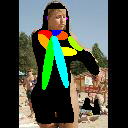

In [357]:
Image.fromarray(background.astype('uint8'), 'RGB')

In [289]:
rectangle = [302, 162, 350, 221, 1, 320, 186, 341, 187, 331, 199, 320, 209, 336,
 211]

In [291]:
W = -int(rectangle[0]) + int(rectangle[2])
H = -int(rectangle[1]) + int(rectangle[3])
paddingH = 0.01 * W
paddingW = 0.02 * H
crop_img = img[int(rectangle[1]+paddingH):int(rectangle[3]-paddingH), int(rectangle[0]-paddingW):int(rectangle[2]+paddingW)]

In [301]:
o = int(rectangle[1]+paddingH):int(rectangle[3]-paddingH), int(rectangle[0]-paddingW):int(rectangle[2]+paddingW)

SyntaxError: invalid syntax (<ipython-input-301-260b67e3025b>, line 1)

[ 92 127 193]
[ 99 134 202]
[107 142 208]
[ 99 134 198]
[ 74 109 172]
[ 47  84 146]
[ 32  71 133]
[ 38  78 137]
[ 55  95 153]
[ 68 109 164]
[ 80 120 172]
[ 79 119 168]
[ 78 117 162]
[ 71 110 155]
[ 57  96 141]
[ 38  76 124]
[ 25  65 114]
[ 28  67 119]
[ 38  77 129]
[ 83 120 170]
[ 92 128 176]
[ 80 113 159]
[ 50  79 123]
[32 58 98]
[34 58 94]
[32 53 85]
[21 39 70]
[23 39 68]
[17 31 60]
[ 9 23 52]
[15 29 58]
[ 3 18 50]
[27 42 74]
[ 56  71 104]
[ 4 21 54]
[101 120 153]
[ 94 115 147]
[ 67  88 120]
[29 52 84]
[34 59 93]
[34 60 96]
[10 36 73]
[14 43 82]
[ 64  94 135]
[ 69 101 142]
[ 77 111 154]
[ 86 121 164]
[ 98 135 179]
[112 149 193]
[115 154 199]
[ 77 112 180]
[ 85 119 189]
[ 91 126 194]
[ 92 127 195]
[ 90 125 193]
[ 75 113 178]
[ 55  93 157]
[ 30  69 131]
[ 21  58 118]
[ 41  79 137]
[ 64 102 156]
[ 71 108 160]
[ 60  97 147]
[ 52  87 137]
[ 49  85 133]
[ 45  80 130]
[ 33  68 118]
[ 18  53 103]
[ 7 42 92]
[ 6 41 91]
[ 53  86 135]
[ 89 119 166]
[ 81 108 152]
[ 49  74 114]
[29 51 87]
[25 44 

[ 52  79 146]
[ 50  76 146]
[ 47  74 141]
[ 42  68 135]
[ 37  63 129]
[ 42  68 134]
[ 51  77 143]
[ 43  68 132]
[ 42  67 131]
[ 40  65 129]
[ 38  63 127]
[ 38  61 123]
[ 37  60 122]
[ 36  59 121]
[ 36  59 121]
[ 31  56 120]
[ 31  56 120]
[ 30  55 117]
[ 31  54 116]
[ 31  52 114]
[ 30  49 110]
[ 29  47 108]
[ 27  45 104]
[ 27  43 102]
[ 28  44 103]
[22 38 97]
[18 37 94]
[21 40 97]
[17 37 92]
[14 34 89]
[ 63  92 166]
[ 82 107 177]
[100 119 176]
[23 33 67]
[ 1  6 27]
[23 24 44]
[27 29 47]
[20 24 43]
[ 7 15 38]
[19 30 60]
[35 54 92]
[101 126 176]
[ 89 119 178]
[ 57  92 156]
[ 50  84 150]
[ 47  79 144]
[ 61  88 152]
[ 76  97 158]
[ 74  95 156]
[ 63  88 152]
[ 57  83 149]
[ 55  81 148]
[ 58  84 150]
[ 61  85 151]
[ 55  80 144]
[ 48  73 137]
[ 43  68 132]
[ 47  69 134]
[ 46  68 133]
[ 44  67 129]
[ 41  64 126]
[ 40  63 125]
[ 38  61 123]
[ 39  60 122]
[ 37  60 122]
[ 33  55 120]
[ 32  54 119]
[ 32  55 117]
[ 32  53 115]
[ 32  51 112]
[ 31  49 110]
[ 29  47 108]
[ 30  46 105]
[ 30  44 103]
[ 2

[ 31  45 103]
[26 40 98]
[ 28  47 104]
[ 53  73 130]
[ 24  46 104]
[13 19 32]
[24 28 33]
[22 27 36]
[ 4 11 36]
[20 32 68]
[ 43  58 104]
[ 47  67 122]
[ 36  63 127]
[ 39  67 138]
[ 41  72 147]
[ 37  67 144]
[ 39  68 143]
[ 42  69 143]
[ 43  68 140]
[ 41  66 136]
[ 36  62 132]
[ 42  70 141]
[ 63  95 168]
[ 88 120 193]
[ 67  96 170]
[ 63  93 164]
[ 56  85 159]
[ 53  81 152]
[ 51  79 150]
[ 50  78 149]
[ 47  75 146]
[ 45  71 141]
[ 58  84 154]
[ 66  91 161]
[ 72  98 165]
[ 72  98 165]
[ 69  92 160]
[ 58  81 149]
[ 45  68 136]
[ 36  58 124]
[ 28  46 107]
[ 26  42 101]
[19 38 95]
[17 36 93]
[19 38 95]
[25 42 99]
[ 32  46 104]
[ 37  49 107]
[ 42  53 110]
[ 40  49 106]
[27 36 93]
[ 34  45 102]
[ 40  55 111]
[ 42  63 118]
[ 7 30 86]
[14 20 31]
[21 27 34]
[11 19 32]
[ 6 17 45]
[25 40 79]
[ 46  61 110]
[ 48  68 125]
[ 44  69 133]
[ 42  71 140]
[ 42  71 146]
[ 42  71 146]
[ 43  69 145]
[ 41  68 142]
[ 42  67 139]
[ 40  66 136]
[ 35  64 133]
[ 34  64 135]
[ 46  76 147]
[ 57  89 162]
[ 73 105 178]
[

[ 43  68 148]
[ 42  66 148]
[ 40  66 150]
[ 41  70 151]
[ 38  68 147]
[ 39  66 146]
[ 40  67 147]
[ 39  67 144]
[ 35  63 140]
[ 38  64 141]
[ 43  69 146]
[ 40  64 140]
[ 42  66 142]
[ 44  67 143]
[ 40  63 139]
[ 36  56 133]
[ 32  52 129]
[ 34  55 130]
[ 39  58 131]
[ 37  56 123]
[ 40  59 120]
[ 44  64 119]
[ 36  56 104]
[17 38 76]
[11 30 63]
[16 30 58]
[14 24 48]
[20 25 50]
[17 21 49]
[ 9 14 47]
[11 20 57]
[ 0 11 54]
[ 40  63 111]
[ 33  61 115]
[ 8 17 30]
[ 1 14 30]
[30 44 73]
[ 36  50 102]
[ 40  58 121]
[ 48  69 137]
[ 49  73 145]
[ 46  75 150]
[ 46  77 156]
[ 46  79 158]
[ 46  79 158]
[ 47  77 154]
[ 48  77 152]
[ 49  76 150]
[ 48  74 150]
[ 47  73 150]
[ 46  71 151]
[ 45  69 153]
[ 42  68 152]
[ 37  67 146]
[ 39  69 146]
[ 39  67 144]
[ 35  63 140]
[ 40  68 145]
[ 47  76 151]
[ 45  71 148]
[ 34  60 136]
[ 46  70 146]
[ 41  65 141]
[ 38  61 137]
[ 36  59 135]
[ 39  59 136]
[ 39  59 136]
[ 36  57 132]
[ 35  54 127]
[ 40  57 124]
[ 41  58 121]
[ 41  59 118]
[ 32  51 102]
[21 38 81]
[22

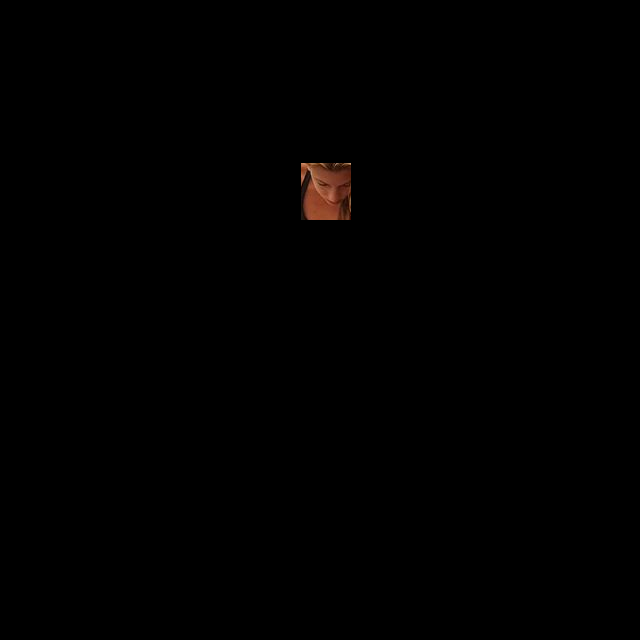

In [340]:
draw = np.zeros(img.shape)
for row in range(draw.shape[0]):
    for px in range(draw.shape[1]):
        if row > int(rectangle[1]+paddingH) and row < int(rectangle[3]-paddingH):
            if px > int(rectangle[0]-paddingW) and px < int(rectangle[2]+paddingW):
                draw[row][px] = img[row][px]
                print(img[row][px])
Image.fromarray(draw.astype('uint8')[:,:,[2,1,0]], 'RGB')

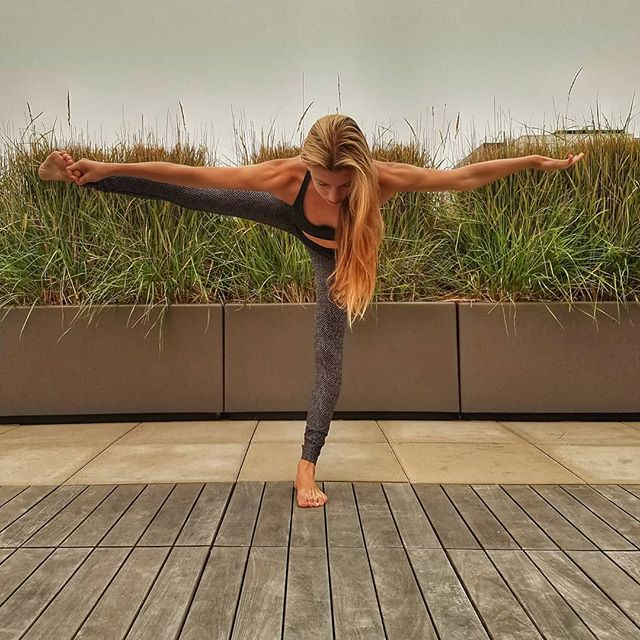

In [338]:
draw = np.zeros(img.shape)
for row in range(draw.shape[0]):
    draw[row] = img[row]
Image.fromarray(draw.astype('uint8')[:,:,[2,1,0]], 'RGB')

In [337]:
draw[draw != img]

array([], dtype=float64)